In [1]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from IPython.core.debugger import set_trace
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import networkx as nx

In [3]:
import umap

In [4]:
#%matplotlib notebook

In [5]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [6]:
client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)
client.materialize.get_tables()

['soma_jan2022',
 'wing_motor_neuron_table_v0',
 'synapses_nov2022',
 'proofread_second_pass',
 'motor_neuron_table_v7',
 'cell_ids',
 'wing_premotor_v4',
 'somas_dec2022',
 'upstream_feco_axons',
 'nucleus_mar2022',
 'proofreading_status_jasper',
 'neuron_somas_dec2022',
 'downstream_feco_axons_v1',
 'synapse_regions_v1',
 'topo_23b_table_v0',
 'downstream_10b_table_v0',
 'downstream_hair_plate_axon_table_v0',
 'proofread_by_andrewcook',
 'glia_somas_dec2022',
 'grooming_command_like_neurons_v1',
 'peripheral_nerves',
 'feco_axons_v0',
 'gustatory_downstream_t1l',
 'upstream_hair_plate_axon_table_v0',
 'sensory_admn_left',
 'left_t1_local_premotor_table_v5',
 'legcs_axons',
 'neck_connective',
 'neuron_information',
 'abdominal_sensory_axon_table_v0',
 'neurotransmitter_hemilineage_table',
 'left_t1_local_premotor_table_v6',
 'downstream_feco_axons_v0',
 'hair_plate_table',
 'downstream_bristle_table_v0',
 'bristle_axon_table',
 'right_to_left_t1_mn_bound2tag_v0',
 'all_leg_motor_neur

In [7]:
# get bristle tables and separate into leg and wing
bristle_df= client.materialize.query_table('bristle_axon_table')
bristle_df.head()
leg_df = bristle_df.loc[bristle_df.classification_system.str.contains("T1_L")]
wing_df = bristle_df[bristle_df.classification_system=='ADMN_L']
leg_filtered_df = leg_df.loc[(leg_df['cell_type']!= 'bristle_unsure')]
gustatory_df = leg_filtered_df.loc[(leg_filtered_df['cell_type'] == "bristle_gustatory_ascending") 
                          | (leg_filtered_df['cell_type'] == "bristle_gustatory")]
tactile_df = leg_filtered_df.loc[(leg_filtered_df['cell_type']== 'bristle_tactile_crossover') 
                          | (leg_filtered_df['cell_type'] == 'bristle_tactile')]
short_df = leg_filtered_df.loc[((leg_df['cell_type'] == 'bristle_unsure_short'))]
bristle_cl_df = leg_filtered_df.loc[((leg_df['cell_type'] == 'Bristle'))]
tactile_df.shape,gustatory_df.shape,leg_filtered_df.shape, short_df.shape, bristle_cl_df.shape

((0, 9), (0, 9), (199, 9), (0, 9), (0, 9))

In [8]:
leg_df = leg_df.replace(to_replace=['bristle_tactile','bristle_tactile_crossover'], value="tactile")
leg_df = leg_df.replace(to_replace=['bristle_gustatory','bristle_gustatory_ascending'], value="gustatory")

C:\Users\trnan\anaconda3\envs\micronsbinder\lib\site-packages\pandas\core\array_algos\replace.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [9]:
dwn_df= client.materialize.query_table('downstream_bristle_table_v0')
print(dwn_df.shape)
dwn_df.head()

(604, 9)


id                          created  superceded_id valid  \
0   882 2022-09-02 16:54:18.932901+00:00            NaN     t   
1  1009 2022-09-02 16:54:43.393997+00:00            NaN     t   
2   836 2022-09-02 16:53:49.188174+00:00            NaN     t   
3   863 2022-09-02 16:54:18.705434+00:00            NaN     t   
4  1146 2022-09-07 23:52:07.033538+00:00            NaN     t   

                    classification_system  \
0                            ax_ascending   
1                                ax_local   
2  ax_ascending_intersegmental_unilateral   
3                            ax_ascending   
4                                ax_local   

                                     cell_type   pt_supervoxel_id  \
0  dend_intersegmental_unilateral_soma_dors_t3  73893228700598830   
1                       dend_local_soma_ven_t1  73398518999798869   
2              dend_intersegmental_soma_ant_t1  73116218718064250   
3  dend_intersegmental_unilateral_soma_dors_t3  73964216457117215   
4                   dend_local_soma_post_t1_3A  72413356178647443   

           pt_root_id            pt_position  
0  648518346481892541    [54208, 181960, 60]  
1  648518346496727932  [39224, 118408, 3549]  
2  648518346479064271   [31552, 92504, 2192]  
3  648518346500008003  [56640, 198952, 1058]  
4  648518346512717214  [11296, 116988, 2762]

In [10]:
partner_class_dct = dict(zip(dwn_df.pt_root_id,dwn_df.classification_system))
partner_cell_dct = dict(zip(dwn_df.pt_root_id, dwn_df.cell_type))
bristle_type_dct = dict(zip(leg_df.pt_root_id, leg_df.cell_type))

In [11]:
type_root_tactile_df = tactile_df[['cell_type','pt_root_id']]
type_root_gustatory_df = gustatory_df[['cell_type','pt_root_id']]
type_root_short_df = short_df[['cell_type','pt_root_id']]
type_root_bristle_df = bristle_cl_df[['cell_type','pt_root_id']]

In [12]:
syn_tactile_down_df = client.materialize.synapse_query(pre_ids=type_root_tactile_df.pt_root_id)

syn_tactile_up_df = client.materialize.synapse_query(post_ids=type_root_tactile_df.pt_root_id)

In [13]:
syn_gustatory_down_df = client.materialize.synapse_query(pre_ids=type_root_gustatory_df.pt_root_id)

syn_gustatory_up_df = client.materialize.synapse_query(post_ids=type_root_gustatory_df.pt_root_id)

In [14]:
syn_short_down_df = client.materialize.synapse_query(pre_ids=type_root_short_df.pt_root_id)

syn_short_up_df = client.materialize.synapse_query(post_ids=type_root_short_df.pt_root_id)

In [15]:
syn_bris_down_df = client.materialize.synapse_query(pre_ids=type_root_bristle_df.pt_root_id)
syn_bris_up_df = client.materialize.synapse_query(post_ids=type_root_bristle_df.pt_root_id)

In [16]:
tac_dwn_lst = syn_tactile_down_df['post_pt_root_id'].unique()
tac_up_lst = syn_tactile_up_df['pre_pt_root_id'].unique()
gust_dwn_lst = syn_gustatory_down_df['post_pt_root_id'].unique()
gust_up_lst = syn_gustatory_up_df['pre_pt_root_id'].unique()
short_dwn_lst = syn_short_down_df['post_pt_root_id'].unique()
short_up_lst = syn_short_up_df['pre_pt_root_id'].unique()
syn_bris_down_lst = syn_bris_down_df['post_pt_root_id'].unique()
syn_bris_up_lst = syn_bris_up_df['pre_pt_root_id'].unique()

In [17]:
len(tac_dwn_lst),len(tac_up_lst),len(gust_dwn_lst),len(gust_up_lst), len(short_dwn_lst), len(short_up_lst)

(0, 0, 0, 0, 0, 0)

In [18]:
#downstream_edges

In [19]:
partner = [*set(np.concatenate([tac_dwn_lst,tac_up_lst,gust_dwn_lst,gust_up_lst,
                                short_dwn_lst,short_up_lst,syn_bris_down_lst,syn_bris_up_lst],
                        axis=0))]

In [20]:
downlist = client.materialize.synapse_query(pre_ids=leg_df.pt_root_id)
uplist = client.materialize.synapse_query(post_ids=leg_df.pt_root_id)
partnerlst = pd.concat([downlist,uplist], axis=0)
partnerlst.shape

(141130, 11)

In [21]:
# for partner in partners
    # if partner has postsynaptic partner as tactile or gustatory
        # partner is upstream of tactile or gustatory
    # if partner has presynaptic partner as tactile or gustatory
        # partner is downstream of tactile or gustatory
    # if partner is both postsynaptic and presynaptic of tactile or gustatory
        # partner is recurrent of tactile or gustatory
def check_partners(dwn_lst, up_lst,partner_lst=partner):
    dct = {partner_lst[i]: 'None' for i in range(0, len(partner_lst))}
    for partner in dct:
        # check dwn_lst
        # if pt_root_id of partner is in dwn_lst --> downstream partner
        if partner in dwn_lst:
            dct[partner] = 'downstream'
        # check up_df
        # if pt_root_id of partner is in up_lst --> upstream partner
        if partner in up_lst:
            dct[partner] = 'upstream'
        # check both
        # if pt_root_id of partner is in both --> recurrent
        if partner in dwn_lst and partner in up_lst:
            dct[partner] = 'recurrent' 
    return dct    

In [22]:
#bristle = 648518346496820708
def check_partners_individual(bristle):
    # query for upstream and downstream partners
    upstream_table = client.materialize.synapse_query(post_ids=bristle)
    downstream_table = client.materialize.synapse_query(pre_ids=bristle)
    
    
    # get uplist through obtaining pre_pt_root_id of its table and dwnlist through post_pt_root_id of its table
    uplist = upstream_table['pre_pt_root_id'].unique()
    downlist = downstream_table['post_pt_root_id'].unique()
    
    # append another column of bristle and partner pt_root_id
    upstream_table['partner_pt_root_id'] = upstream_table['pre_pt_root_id']
    upstream_table['bristle_pt_root_id'] = upstream_table['post_pt_root_id']
    downstream_table['partner_pt_root_id'] = downstream_table['post_pt_root_id']
    downstream_table['bristle_pt_root_id'] = downstream_table['pre_pt_root_id']
    
    # concat the tables
    df = pd.concat([upstream_table, downstream_table], axis=0)
    # concat up and dwn list for partner list
    partner_lst = [*set(np.concatenate([uplist,downlist], axis=0))]
    
    # use check_partners to obtain mapping dct
    dct = check_partners(downlist, uplist, partner_lst=partner_lst)
    
    # map each partner to the mapping dct
    df['label'] = df['partner_pt_root_id'].map(dct)
    return df

In [23]:
def get_clustered_order(sim_mat, distance_threshold = 0, 
                       n_clusters = None, **kwargs):
    
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None).fit(sim_mat)
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    
    parsed_order = []
    for c in clustered_order:
        if '(' in c:
            c = c.split('(')[1]
            c = c.split(')')[0]
        parsed_order.append(int(c))
    
    return parsed_order

In [24]:
# initialize a dataframe
# for each bristle in bristles  648518346496820708
df = check_partners_individual(leg_df[leg_df.pt_root_id==648518346496820708].pt_root_id)
for bristle in leg_df[leg_df.pt_root_id!=648518346496820708].pt_root_id.unique().tolist():
    df1 = check_partners_individual(bristle)
    # concat the current bristle dataframe with the just made bristle dataframe
    df = pd.concat([df, df1], axis=0)

In [25]:
df.shape

(141130, 14)

In [26]:
df['partner_classification_system'] = df['partner_pt_root_id'].map(partner_class_dct)
df['partner_cell_type'] = df['partner_pt_root_id'].map(partner_cell_dct)
df['bristle_type'] = df['bristle_pt_root_id'].map(bristle_type_dct)

In [27]:
df.shape

(141130, 17)

In [28]:
#df.to_pickle("C:/Users/trnan/OneDrive/Desktop/uw/Tutill lab/repos/df")

In [29]:
df_edges = df.groupby(['pre_pt_root_id', 'post_pt_root_id','partner_pt_root_id','bristle_pt_root_id',
                       'label', 'bristle_type','partner_classification_system', 'partner_cell_type'], dropna=False).size().sort_values(ascending=False).reset_index(name='count')
df_edges = df_edges.query('count > 3')

In [30]:
df_edges.label.value_counts()

downstream    2719
recurrent     2324
upstream       325
Name: label, dtype: int64

In [31]:
upstream_edges = df_edges.loc[(df_edges.bristle_pt_root_id==df_edges.post_pt_root_id)]
downstream_edges = df_edges.loc[(df_edges.bristle_pt_root_id == df_edges.pre_pt_root_id)]

In [32]:
def sns_hist_cos_sim(edges, df_edges, bins, hue='label', choice=1, title="Types of Connectivity"):
    # downstream edges
    edges = edges

    # pre and post pt_root_ids list
    if choice == 1:
        pre = edges.pre_pt_root_id.unique().tolist()
        post = edges.post_pt_root_id.unique().tolist()
    else:
        post = edges.pre_pt_root_id.unique().tolist()
        pre = edges.post_pt_root_id.unique().tolist()

    # initialize conn_mat with length of pre and post pt_root_ids
    conn_mat = np.zeros((len(pre),len(post)))
    print(conn_mat.shape)

    # enumerate every pre_pt_root_id in pre list
    for ix, i in enumerate(pre):
        # locates rows with pre_pt_root_id as such
        subset = edges[edges.pre_pt_root_id == i]

        for jx, j in enumerate(post):
            if j in subset.post_pt_root_id.tolist():
                c = subset[subset.post_pt_root_id==j]['count'].tolist()[0]
                conn_mat[ix,jx] = c
    sim_mat = cosine_similarity(conn_mat)
    clustered_order = get_clustered_order(sim_mat)
#    ids_ordered = [pre[i] for i in clustered_order]
    smth = [pre[i] for i in clustered_order]
    ids_ordered = dict(zip(smth,[i for i in range(len(smth))]))

#     order = []
#     df_edges= df_edges
#     for i in df_edges.bristle_pt_root_id:
#         ix = 140
#         for jx, j in enumerate(ids_ordered):
#             if i == j:
#                 ix = jx

#         order.append(ix)
#    df_edges['order'] = order 
    df_edges['order'] = df_edges['bristle_pt_root_id'].map(ids_ordered)
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(1,1,1)

    sns.histplot(data=df_edges, ax=ax, multiple="stack",
                 x="order", bins = bins,
                 palette="Paired", hue=hue, 
                 element="bars", legend=True)
    ax.set_title(title)
    ax.set_xlabel("Bristle Axon")
    ax.set_ylabel("Number of Connections") # number of partners connected to
    sns.move_legend(ax, "upper right",frameon=False,bbox_to_anchor=(1.15, 1))
    #plt.savefig('../Bristle_project/figures/celltype_downstream_input_conn.png')
    return df_edges

In [127]:
bins = len(downstream_edges.pre_pt_root_id.unique())

(198, 829)


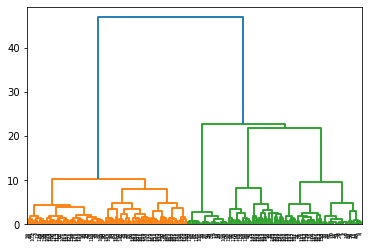

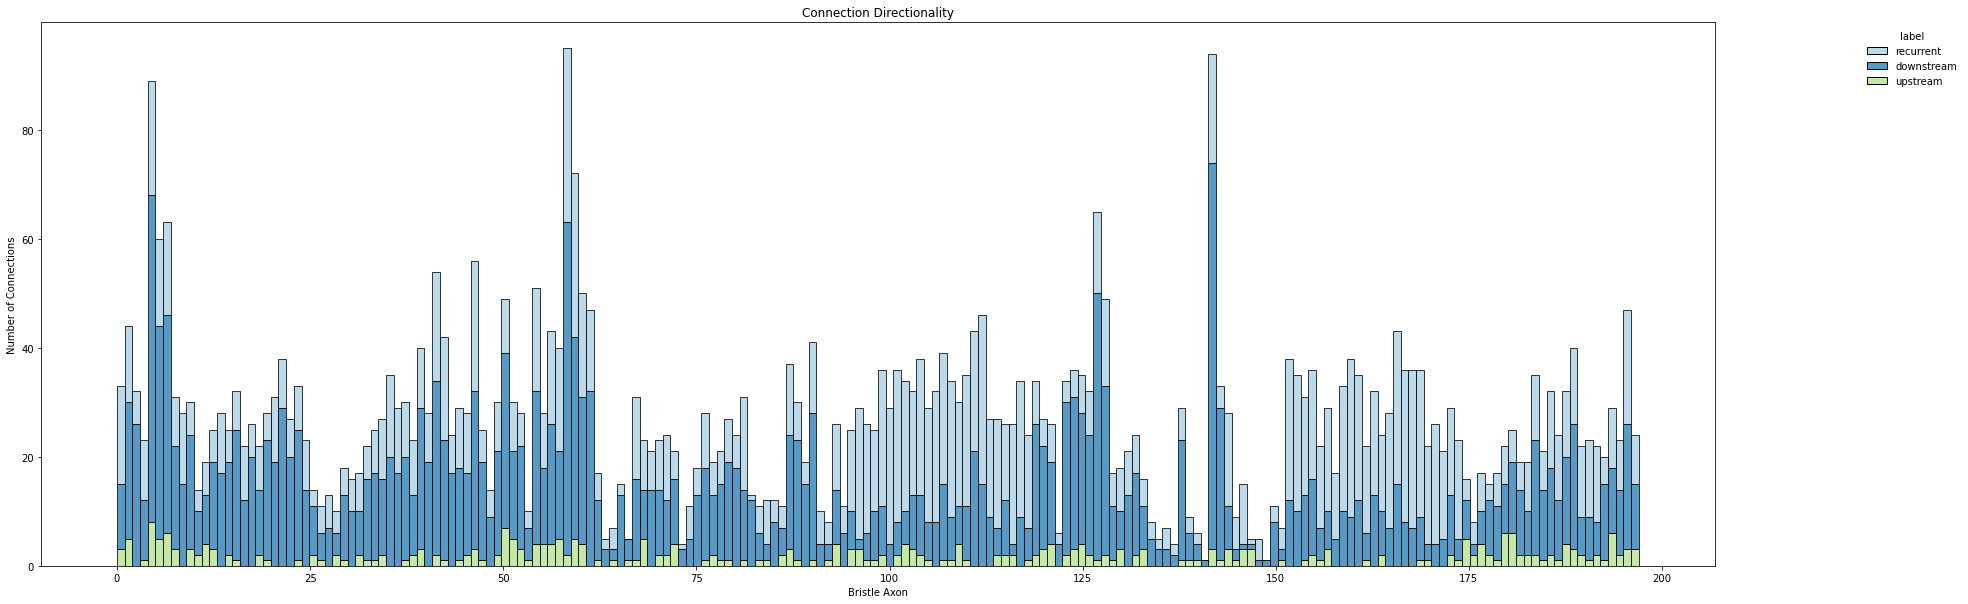

In [128]:
downs = sns_hist_cos_sim(downstream_edges, df_edges, bins, title='Connection Directionality')

In [129]:
df_edges.head()

pre_pt_root_id     post_pt_root_id  partner_pt_root_id  \
0  648518346494876298  648518346502021449  648518346502021449   
1  648518346490400604  648518346502021449  648518346502021449   
2  648518346480804573  648518346502021449  648518346502021449   
3  648518346486376873  648518346495973195  648518346495973195   
4  648518346494129655  648518346502021449  648518346502021449   

   bristle_pt_root_id      label         bristle_type  \
0  648518346494876298  recurrent   anterior_crossover   
1  648518346490400604  recurrent   anterior_crossover   
2  648518346480804573  recurrent   anterior_crossover   
3  648518346486376873  recurrent   anterior_crossover   
4  648518346494129655  recurrent  posterior_crossover   

  partner_classification_system                            partner_cell_type  \
0                  ax_ascending  dend_intersegmental_unilateral_soma_dors_t3   
1                  ax_ascending  dend_intersegmental_unilateral_soma_dors_t3   
2                  ax_ascending  dend_intersegmental_unilateral_soma_dors_t3   
3                         local                                          23B   
4                  ax_ascending  dend_intersegmental_unilateral_soma_dors_t3   

   count  order  
0     90    196  
1     71    186  
2     66    187  
3     59      5  
4     57    197

(198, 829)


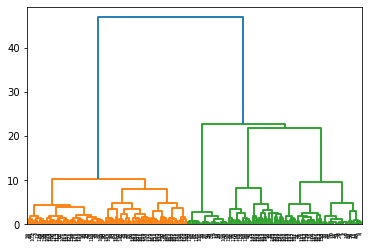

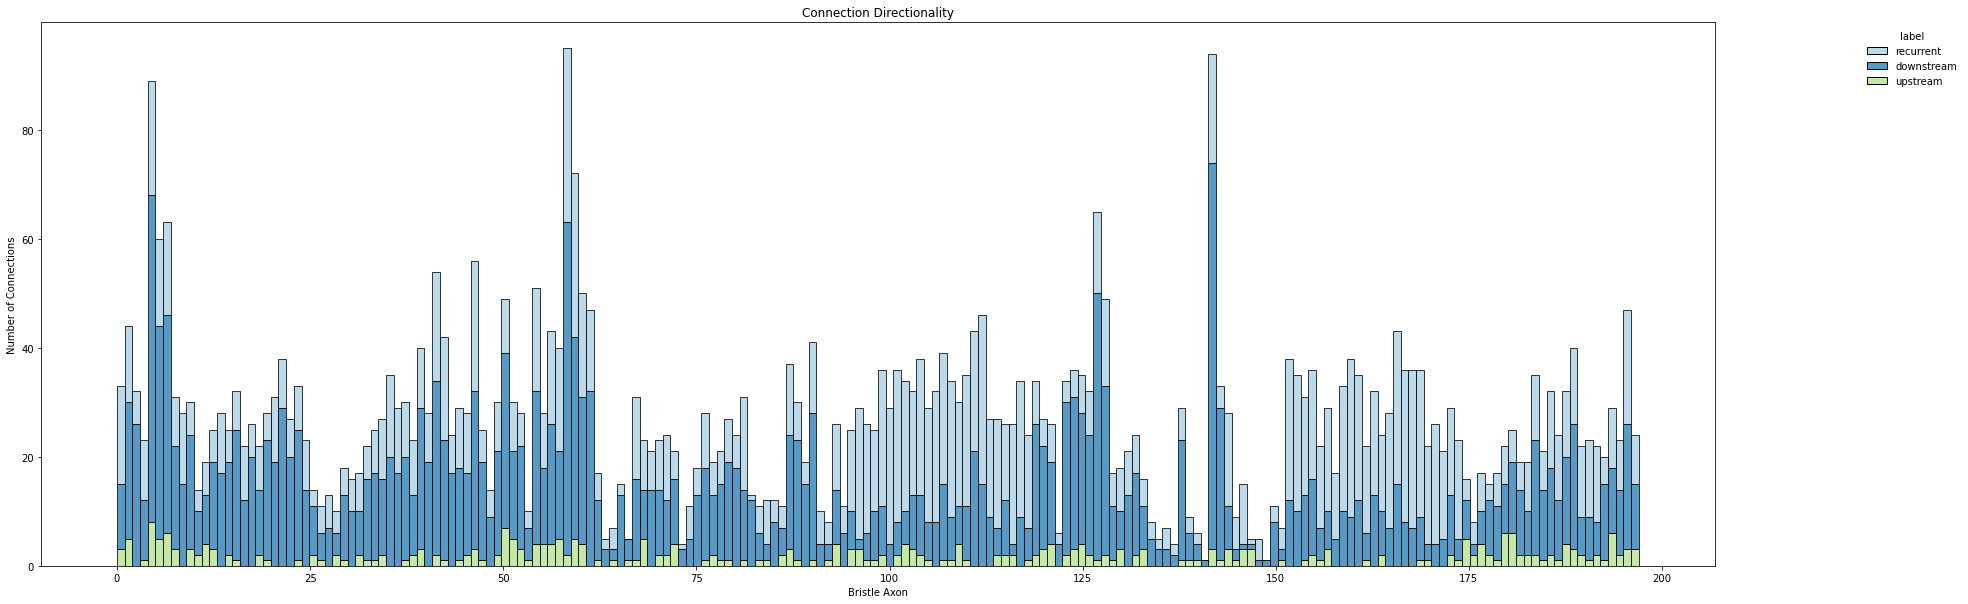

In [130]:
downs = sns_hist_cos_sim(downstream_edges, df_edges, bins, title='Connection Directionality')

In [36]:
def coor_dct(df, of, to):
    coor_dict = dict(zip(df[of].unique(), [0 for i in range(df.shape[0])]))
    label_lst = [*df[to].unique()]
    for an_id in [*df[of].unique()]:
        coordinate = [0 for i in range(len(label_lst))]
        for ith, some_label in enumerate(label_lst):
            if not df.query(f"{of}=={an_id} & {to}=='{some_label}'").empty and some_label!='recurrent':
                coordinate[ith] = df.query(f"{of}=={an_id} & {to}=='{some_label}'")['count'].iat[0]
            elif not df.query(f"{of}=={an_id} & {to}=='{some_label}'").empty and some_label=='recurrent':
                coordinate[ith] = df.query(f"{of}=={an_id} & {to}=='{some_label}'")['subrecurrent'].iat[0]
        coordinate = tuple(coordinate)
        coor_dict.update({an_id:coordinate})
    return coor_dict, label_lst

In [37]:
def stack_coordinates(col):
    return np.vstack(col)

# this assumes that df has a coordinate column in x,y,z (already in its right units)
def plot_3d_scatter_pyplot(df, query_for):
    # gets x,y,z from (x,y,z)
    x = stack_coordinates(df[df.partner_cell_type==query_for].coordinate)[:,0]
    y = stack_coordinates(df[df.partner_cell_type==query_for].coordinate)[:,1]
    z = stack_coordinates(df[df.partner_cell_type==query_for].coordinate)[:,2]
    
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)
    ax.scatter(xs=x,ys=y,zs=z, c='partner_cell_type')
    
    ax.set_xlabel('Downstream')
    ax.set_ylabel('Upstream')
    ax.set_zlabel('Recurrent')
    
    fig.show()
    
def plot_3d_scatter_plotly(df, query_for=['Bristle'], marker_size=3.5, full_recurrent=False):
    df2 = None
    for cell_type in query_for:
        df3 = df.loc[(df.partner_cell_type==cell_type)]
        df2 = pd.concat([df2, df3])
    x = stack_coordinates(df2.coordinate)[:,0]
    y = stack_coordinates(df2.coordinate)[:,1]
    if not full_recurrent:
        z = stack_coordinates(df2.coordinate)[:,2]
    else:
        z = stack_coordinates(df2['recurrent_count'])[:,0]
    fig = px.scatter_3d(df2, x=x, y=y, z=z, color='partner_cell_type',
                        labels={'x':'Downstream', 'y':'Upstream', 'z':'Recurrent'})
    fig.update_traces(marker_size=marker_size)
    fig.show()

In [38]:
another = downs.copy()

In [39]:
another.head(1)

pre_pt_root_id     post_pt_root_id  partner_pt_root_id  \
0  648518346494876298  648518346502021449  648518346502021449   

   bristle_pt_root_id      label        bristle_type  \
0  648518346494876298  recurrent  anterior_crossover   

  partner_classification_system                            partner_cell_type  \
0                  ax_ascending  dend_intersegmental_unilateral_soma_dors_t3   

   count  order  
0     90    196

In [40]:
def get_projected_df(df_full, **kwargs):
    df_bristle_count = df_full.groupby(['bristle_pt_root_id','partner_cell_type', 'bristle_type'])['count'].sum().reset_index()
    bristle_dict, *vector_order = coor_dct(df_bristle_count, 'bristle_pt_root_id', 'partner_cell_type')
    df_bristle_count['bristle_coordinate'] = df_bristle_count.bristle_pt_root_id.map(bristle_dict)
    reducer = umap.UMAP(**kwargs)
    data = [i for i in bristle_dict.values()]
    scaled_data = StandardScaler().fit_transform(data)
    transformed_data = reducer.fit_transform(scaled_data)
#     projected_vector1 = dict(zip([i for i in bristle_dict.keys()],[i for i in transformed_data[:,0]]))
#     projected_vector2 = dict(zip([i for i in bristle_dict.keys()],[i for i in transformed_data[:,1]]))
    bristle_type_count = df_bristle_count.groupby(['bristle_pt_root_id','bristle_type']).sum().reset_index()
    bristle_type_count['umap_1'] = transformed_data[:,0]
    bristle_type_count['umap_2'] = transformed_data[:,1]
    return bristle_type_count, bristle_dict

In [41]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [42]:
    df_bristle_count = another.groupby(['bristle_pt_root_id','partner_cell_type', 'bristle_type'])['count'].sum().reset_index()
    bristle_dict, *vector_order = coor_dct(df_bristle_count, 'bristle_pt_root_id', 'partner_cell_type')
    df_bristle_count['bristle_coordinate'] = df_bristle_count.bristle_pt_root_id.map(bristle_dict)


In [43]:
    reducer = umap.UMAP()
    data = [i for i in bristle_dict.values()]
    scaled_data = StandardScaler().fit_transform(data)
    transformed_data = reducer.fit_transform(scaled_data)


In [44]:
bristle_type_count = df_bristle_count.groupby(['bristle_pt_root_id','bristle_type']).sum().reset_index()

In [45]:
type(transformed_data[0,0])

numpy.float32

In [46]:
bristle_type_count['umap_1'] = transformed_data[:,0].astype(float)

In [47]:
bristle_type_count

bristle_pt_root_id              bristle_type  count  umap_1
0    648518346465965360            posterior_gust    279  -0.396
1    648518346466864238  anterior_short_bilateral    133   8.377
2    648518346467006190             anterior_gust    150   0.781
3    648518346467014126          posterior_medial    170   0.633
4    648518346467113710             anterior_ipsi     39  10.758
..                  ...                       ...    ...     ...
193  648518346517760360            posterior_gust    145   0.355
194  648518346518790367        anterior_crossover    181  11.743
195  648518346520556598             anterior_gust    249   0.779
196  648518346524129285             anterior_ipsi     88  10.930
197  648518346526236887             anterior_ipsi     50  11.653

[198 rows x 4 columns]

In [48]:
    projected_vector1 = dict(zip([i for i in bristle_dict.keys()],[i for i in transformed_data[:,0]]))
    projected_vector2 = dict(zip([i for i in bristle_dict.keys()],[i for i in transformed_data[:,1]]))
    bristle_type_count = df_bristle_count.groupby(['bristle_pt_root_id','bristle_type']).sum().reset_index()
    bristle_type_count['umap_1'] = transformed_data[:,0]
    bristle_type_count['umap_2'] = transformed_data[:,1]


In [49]:
bristle_type_count, dict1 = get_projected_df(another)

In [50]:
bristle_type_count

bristle_pt_root_id              bristle_type  count  umap_1  umap_2
0    648518346465965360            posterior_gust    279  -2.996   3.976
1    648518346466864238  anterior_short_bilateral    133  19.400   3.953
2    648518346467006190             anterior_gust    150  -0.325   5.924
3    648518346467014126          posterior_medial    170  -0.305   5.180
4    648518346467113710             anterior_ipsi     39  17.878   2.099
..                  ...                       ...    ...     ...     ...
193  648518346517760360            posterior_gust    145  -0.419   6.052
194  648518346518790367        anterior_crossover    181  15.916   4.378
195  648518346520556598             anterior_gust    249   0.248   6.511
196  648518346524129285             anterior_ipsi     88  17.574   2.711
197  648518346526236887             anterior_ipsi     50  17.175   1.880

[198 rows x 5 columns]

In [51]:
def scatter_2d_only(df_with_coor, col='bristle_type', only=[]):
    if len(only) != 0:
        df2 = None
        for label in only:
            df3 = df_with_coor.loc[(df_with_coor[col]==label)]
            df2 = pd.concat([df2, df3])
    else:
        df2 = df_with_coor
#     x = stack_coordinates(df2.coordinate)[:, 0]
#     y = stack_coordinates(df2.coordinate)[:, 1]
    sns.scatterplot(
        df2.umap_1, df2.umap_2, hue = df2[col]
    )
    plt.legend(loc = 2, bbox_to_anchor = (1,1))

In [52]:
bristle_type_count.query('umap_1 < 8 & umap_2 > 10').bristle_pt_root_id.to_list()

[]

In [53]:
bristle_type_count.query('umap_1 < 7 & umap_1 > 5 & umap_2 < 9').bristle_pt_root_id.to_list()

[]

C:\Users\trnan\anaconda3\envs\micronsbinder\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


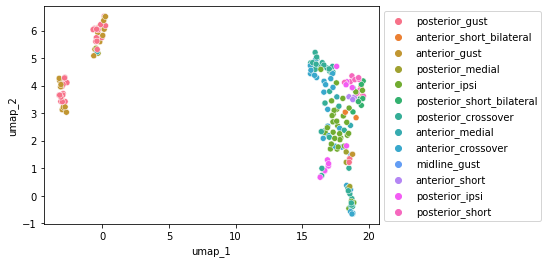

In [54]:
scatter_2d_only(bristle_type_count, only=[])

In [55]:
partner_dct = dict(zip(another.partner_pt_root_id.unique(),[0 for i in range(len(another.partner_pt_root_id.unique()))]))
for partner in partner_dct:
    df2 = downs.query(f'label == "recurrent" & partner_pt_root_id == {partner} & pre_pt_root_id == {partner}')
    count = sum(df2['count'])
    partner_dct[partner] = count

In [56]:
another['subrecurrent'] = another.partner_pt_root_id.map(partner_dct)

In [57]:
synapse_count = another.groupby(['partner_pt_root_id','label','partner_cell_type','subrecurrent'])['count'].sum().reset_index()

In [58]:
def get_coor(df_grouped):
    coor_dict = dict(zip(df_grouped.partner_pt_root_id.unique(), [0 for i in range(df_grouped.shape[0])]))
    dict_recurrent = dict(zip(df_grouped.partner_pt_root_id.unique(), [0 for i in range(df_grouped.shape[0])]))
    for partner in [*df_grouped.partner_pt_root_id.unique()]:
        coordinate = [0,0,0]
        if not df_grouped.query(f"partner_pt_root_id=={partner} & label=='downstream'").empty:
            coordinate[0] = df_grouped.query(f"partner_pt_root_id=={partner} & label=='downstream'")['count'].iat[0]
        if not df_grouped.query(f"partner_pt_root_id=={partner} & label=='upstream'").empty:
            coordinate[1] = df_grouped.query(f"partner_pt_root_id=={partner} & label=='upstream'")['count'].iat[0]
        if not df_grouped.query(f"partner_pt_root_id=={partner} & label=='recurrent'").empty:
            coordinate[2] = df_grouped.query(f"partner_pt_root_id=={partner} & label=='recurrent'")['subrecurrent'].iat[0]
            dict_recurrent[partner] = df_grouped.query(f"partner_pt_root_id=={partner} & label=='recurrent'")['count'].iat[0]
        coordinate = tuple(coordinate)
        coor_dict.update({partner:coordinate})
    df_grouped['coordinate'] = df_grouped['partner_pt_root_id'].map(coor_dict)
    df_grouped['recurrent_count'] = df_grouped['partner_pt_root_id'].map(dict_recurrent)
    return df_grouped

In [59]:
synapse_count = get_coor(synapse_count)

In [60]:
stack_coordinates(synapse_count['recurrent_count'])[:].shape

(655, 1)

In [61]:
another.partner_cell_type.unique()

array(['dend_intersegmental_unilateral_soma_dors_t3', '23B',
       'midline_intersegmental', 'intersegmental', 'local_ascending',
       'dend_local_soma_ven_t1', 'dend_intersegmental_bilateral_soma_t3',
       'dend_local_soma_ven_t1_13B', 'ascending', 'descending',
       'dend_intersegmental_soma_ant_t1',
       'dend_local_midline_soma_ven_t1', 'dend_local_soma_ant_t1',
       'dend_local_soma_post_t1_1B', nan, 'dend_local_soma_dors_t1_23B',
       'local', 'Bristle', 'dend_local_soma_ant_t1_14A',
       'dend_local_soma_post_t1', 'dend_local_soma_dors_t1',
       'dend_local_soma_ven_t1_20A', 'dend_intersegmental_soma_ven_t1',
       'sensory', 'dend_local_soma_post_t1_3A', 'unsure', 'midline',
       'midline_motor_ascending', 'dend_local_soma_ant_t1_16B',
       'dend_intersegmental_unilateral_soma_t3',
       'dend_intersegmental_soma_ven_wing',
       'local_intersegmental_ascending', 'dend_local_soma_ant_t1_9A',
       'dend_local_soma_dors_t1_19A', 'midline_intersegmental_a

In [62]:
plot_3d_scatter_plotly(synapse_count, query_for=[
       'dend_local_soma_ven_t1_13B', 'dend_local_soma_ant_t1_9A',
       'dend_local_soma_ant_t1', 'dend_local_soma_ven_t1_20A',
        'dend_local_soma_dors_t1_23B',
       'dend_local_soma_ant_t1_14A', 'dend_local_soma_ant_t1_10B'], full_recurrent=False)

In [63]:
%matplotlib inline
# tot_df is of order and count column only and comprises ALL the counts
# label_df is of order and count column only and comprises parts of counts
def get_full_axon_df(tot_df, label_df):
    lst = [i for i in range(tot_df.shape[0])]
    dct2 = dict(zip(label_df['order'], label_df['count']))
    dct1 = {lst[i]: 0 for i in range(len(lst))}
    dct1.update(dct2)
    keys = list(dct1.keys())
    vals = list(dct1.values())
    new_dct = {'order':keys, 'count':vals}
    df = pd.DataFrame(data=new_dct)
    return df

def get_count_synapse(df, tot, column='label', test='upstream', groupby='order'):
    if isinstance(test, str):
        up = df[df[column]==test].groupby(groupby)['count'].sum().reset_index()
        up = get_full_axon_df(tot, up)
    else:
        up = df[df[column].isna()].groupby(groupby)['count'].sum().reset_index()
        up = get_full_axon_df(tot, up)
    return up

def get_count_by_proportionality(df, test, df_groupby_total, label, column='label'):
    df_portion = get_count_synapse(df, df_groupby_total, test=test, column=column)
    df_portion['count'] = [i / j * 100 for i,j in zip(df_portion['count'], df_groupby_total['count'])]
    df_portion.name = str(label);
    return df_portion

def plot_percent_stacked_bar(total, args, x='order', only=[]):
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(1,1,1)
    bottom = [0 for i in range(total.shape[0])]
    if len(only) != 0:
        for arg in args:
            if arg.name in only:
                ax.bar(arg[x], arg['count'], bottom=bottom, edgecolor='white', label=arg.name)
                bottom = [i+j for i,j in zip(bottom, arg['count'])]
            else:    
                ax.bar(arg[x], arg['count'], color='#808080', bottom=bottom, edgecolor='white')
                bottom = [i+j for i,j in zip(bottom, arg['count'])]
    else:
        for arg in args:
           ax.bar(arg[x], arg['count'], bottom=bottom, edgecolor='white', label=arg.name)
           bottom = [i+j for i,j in zip(bottom, arg['count'])]
    plt.legend(loc='lower right', bbox_to_anchor=(1,1), ncol=1, prop={"size":20})
    
# master_df (df for short) needs count of synapse column ('count') and order/bristle/pt_root_id of interest to groupby
# column is the column's name by which the hue by which the bar chart is plotted
# groupby is the order/bristle/pt_root_id column to groupby
# only is a list of labels that are plotted with color (others are plotted with grey)
    # only is an empty list by default. Will plot everything with colors if empty.
def plot_percent_stacked_bar_column(df, column, groupby='order', only=[]):
    total = df.groupby(groupby)['count'].sum().reset_index()
    label_lst = [*df[column].unique()]
    subdf_lst = []
    for label in label_lst:
        subdf_lst.append(get_count_by_proportionality(df, label, total, label, column=column))
    plot_percent_stacked_bar(total, subdf_lst, only=only)

In [64]:
downs.partner_cell_type.unique()

array(['dend_intersegmental_unilateral_soma_dors_t3', '23B',
       'midline_intersegmental', 'intersegmental', 'local_ascending',
       'dend_local_soma_ven_t1', 'dend_intersegmental_bilateral_soma_t3',
       'dend_local_soma_ven_t1_13B', 'ascending', 'descending',
       'dend_intersegmental_soma_ant_t1',
       'dend_local_midline_soma_ven_t1', 'dend_local_soma_ant_t1',
       'dend_local_soma_post_t1_1B', nan, 'dend_local_soma_dors_t1_23B',
       'local', 'Bristle', 'dend_local_soma_ant_t1_14A',
       'dend_local_soma_post_t1', 'dend_local_soma_dors_t1',
       'dend_local_soma_ven_t1_20A', 'dend_intersegmental_soma_ven_t1',
       'sensory', 'dend_local_soma_post_t1_3A', 'unsure', 'midline',
       'midline_motor_ascending', 'dend_local_soma_ant_t1_16B',
       'dend_intersegmental_unilateral_soma_t3',
       'dend_intersegmental_soma_ven_wing',
       'local_intersegmental_ascending', 'dend_local_soma_ant_t1_9A',
       'dend_local_soma_dors_t1_19A', 'midline_intersegmental_a

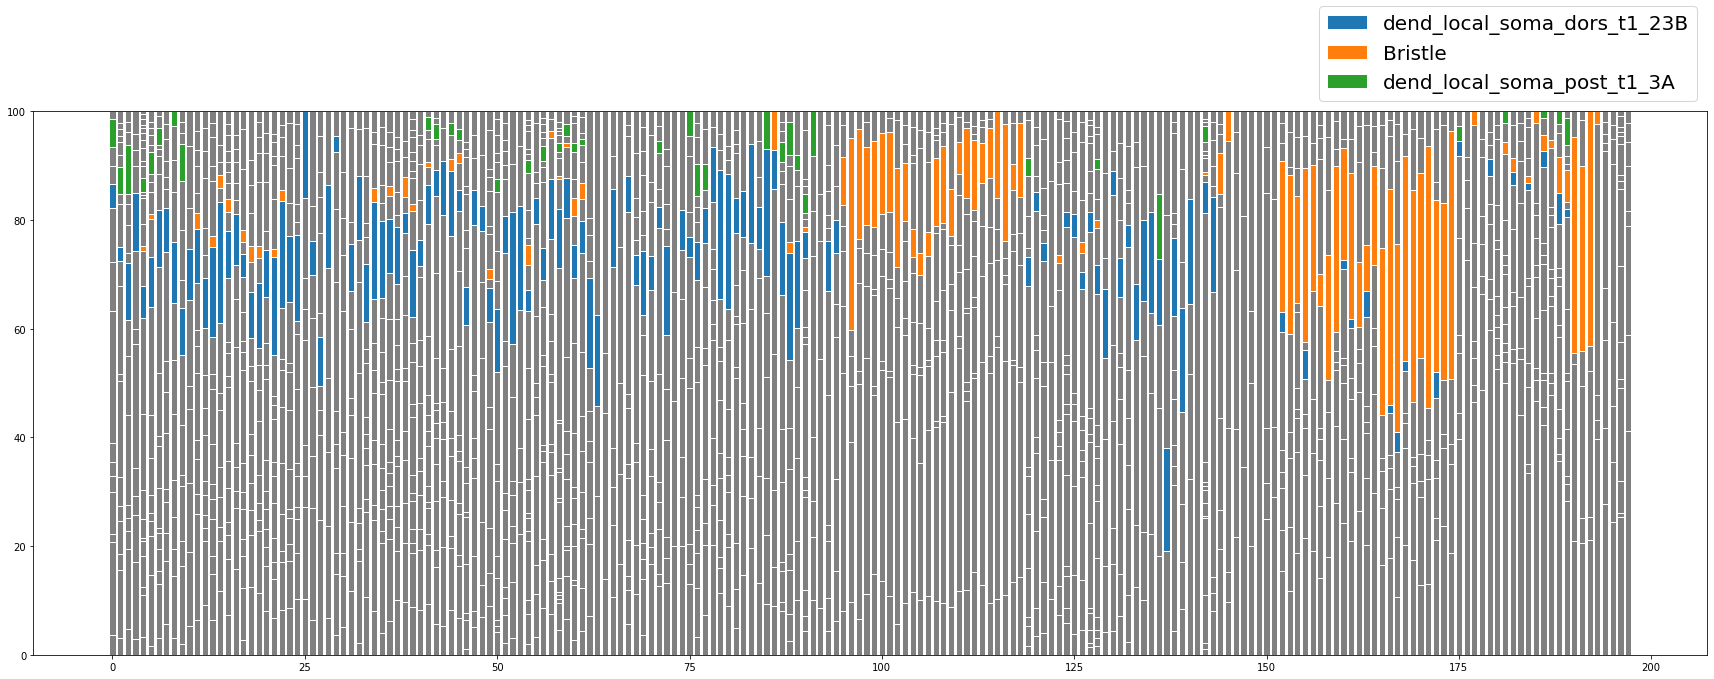

In [65]:
plot_percent_stacked_bar_column(downs, 'partner_cell_type', only=['Bristle', 'dend_local_soma_post_t1_3A','dend_local_soma_dors_t1_23B'])

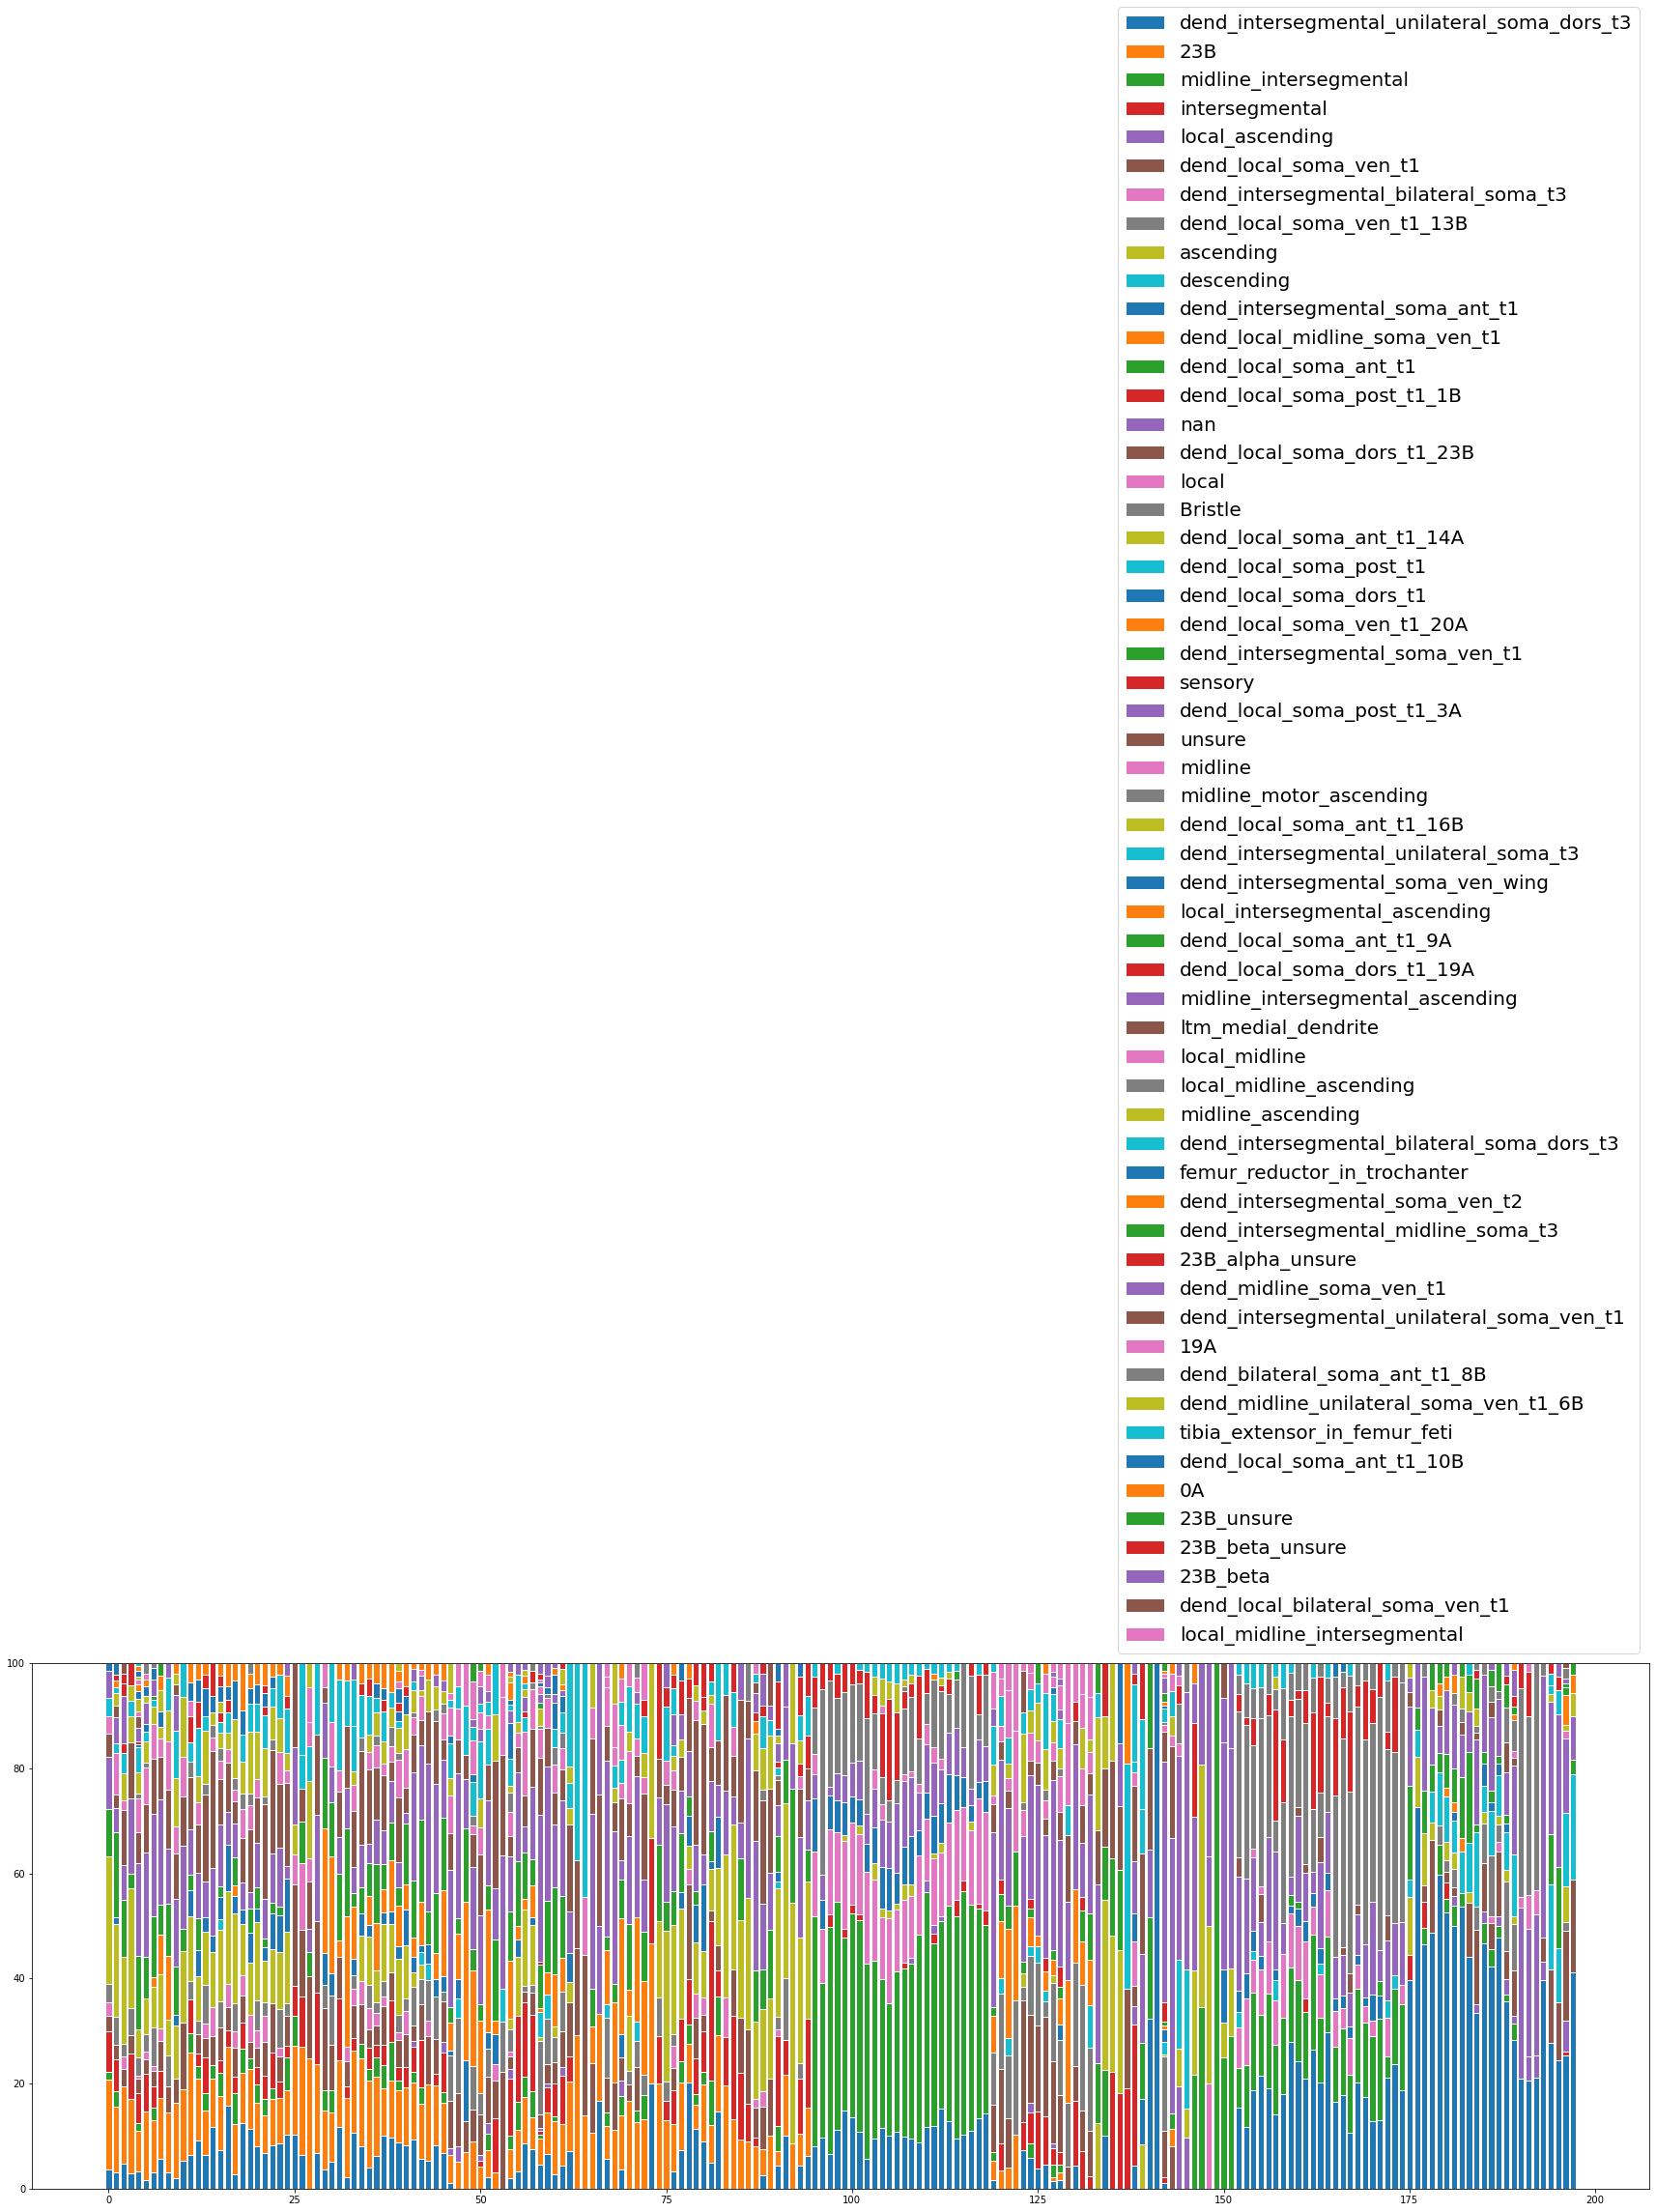

In [66]:
plot_percent_stacked_bar_column(downs, 'partner_cell_type', only=[])

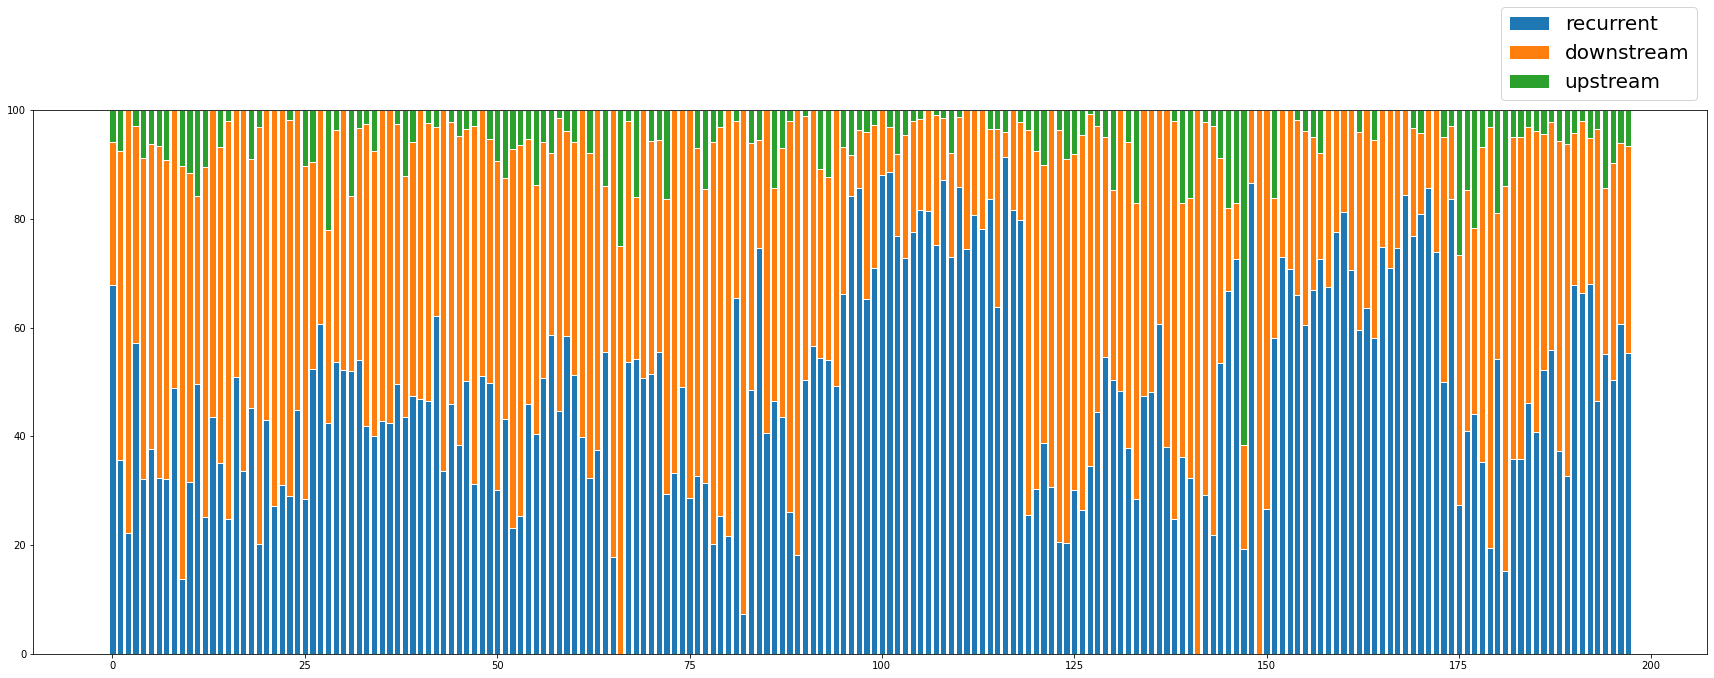

In [67]:
plot_percent_stacked_bar_column(downs, 'label', groupby='order', only=[])

In [68]:
# #plt.bar(tot.order, tot['count'], color='#b5ffb9', edgecolor='white', label="total")
# f = plt.figure(figsize=(30,10))
# ax = f.add_subplot(1,1,1)
# ax.bar(up.order, up['count'], color='#f9bc86', edgecolor='white', label="upstream")
# ax.bar(down.order, down['count'], bottom=up['count'], color='#a3acff', edgecolor='white', label="downstream")
# ax.bar(rec.order, rec['count'], bottom=[i+j for i,j in zip(up['count'], down['count'])], color='#b5ffb9', edgecolor='white', label="recurrent")
# plt.legend(loc='upper right', bbox_to_anchor=(1,1), ncol=1, prop={"size":20})

(198, 829)


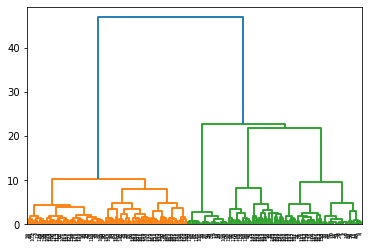

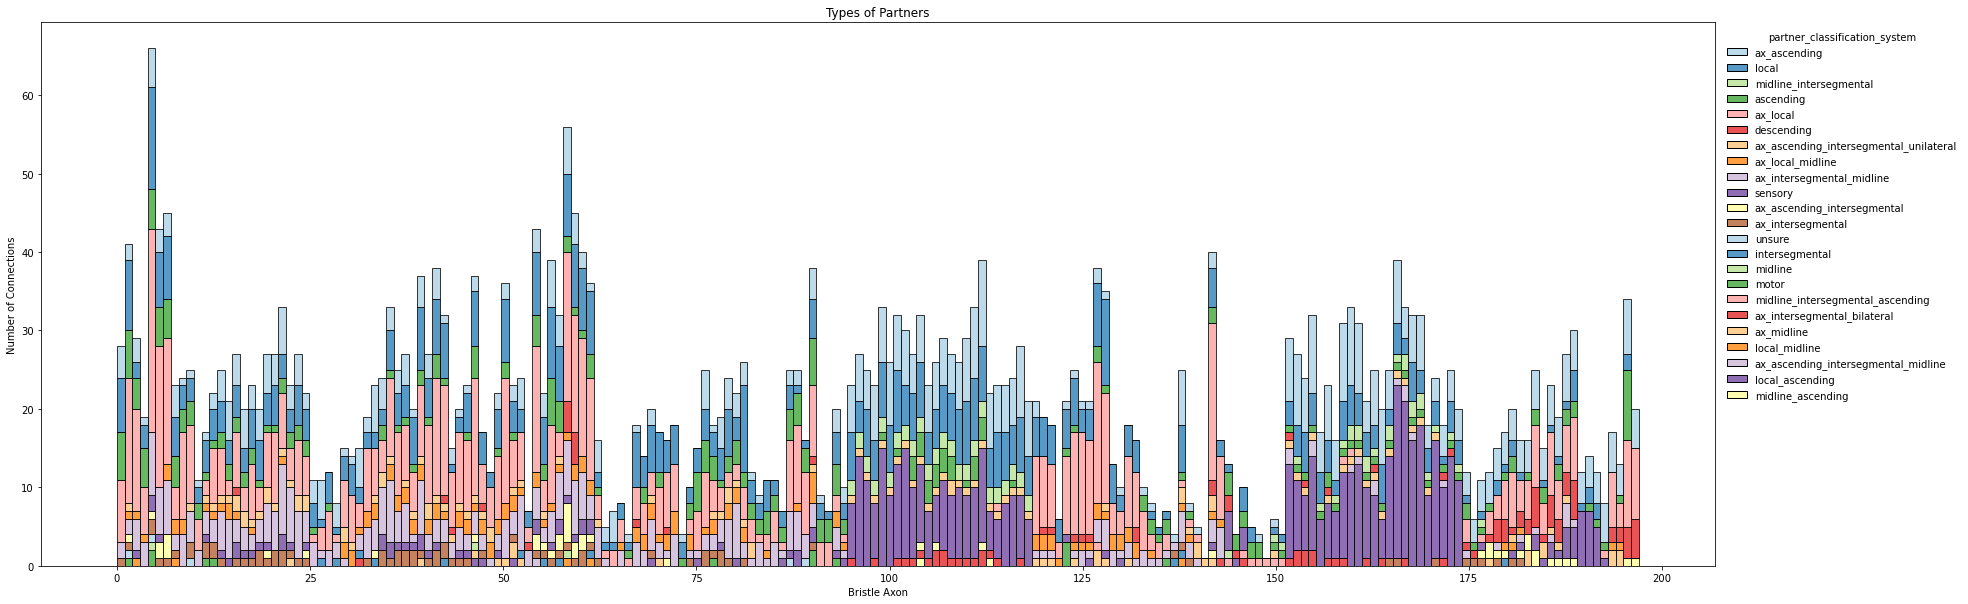

In [69]:
downs = sns_hist_cos_sim(downstream_edges, df_edges, bins, hue='partner_classification_system', title='Types of Partners')

(198, 829)


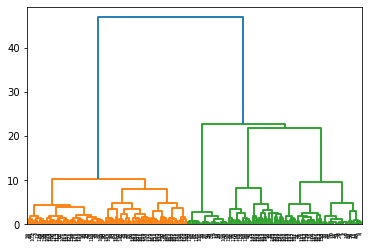

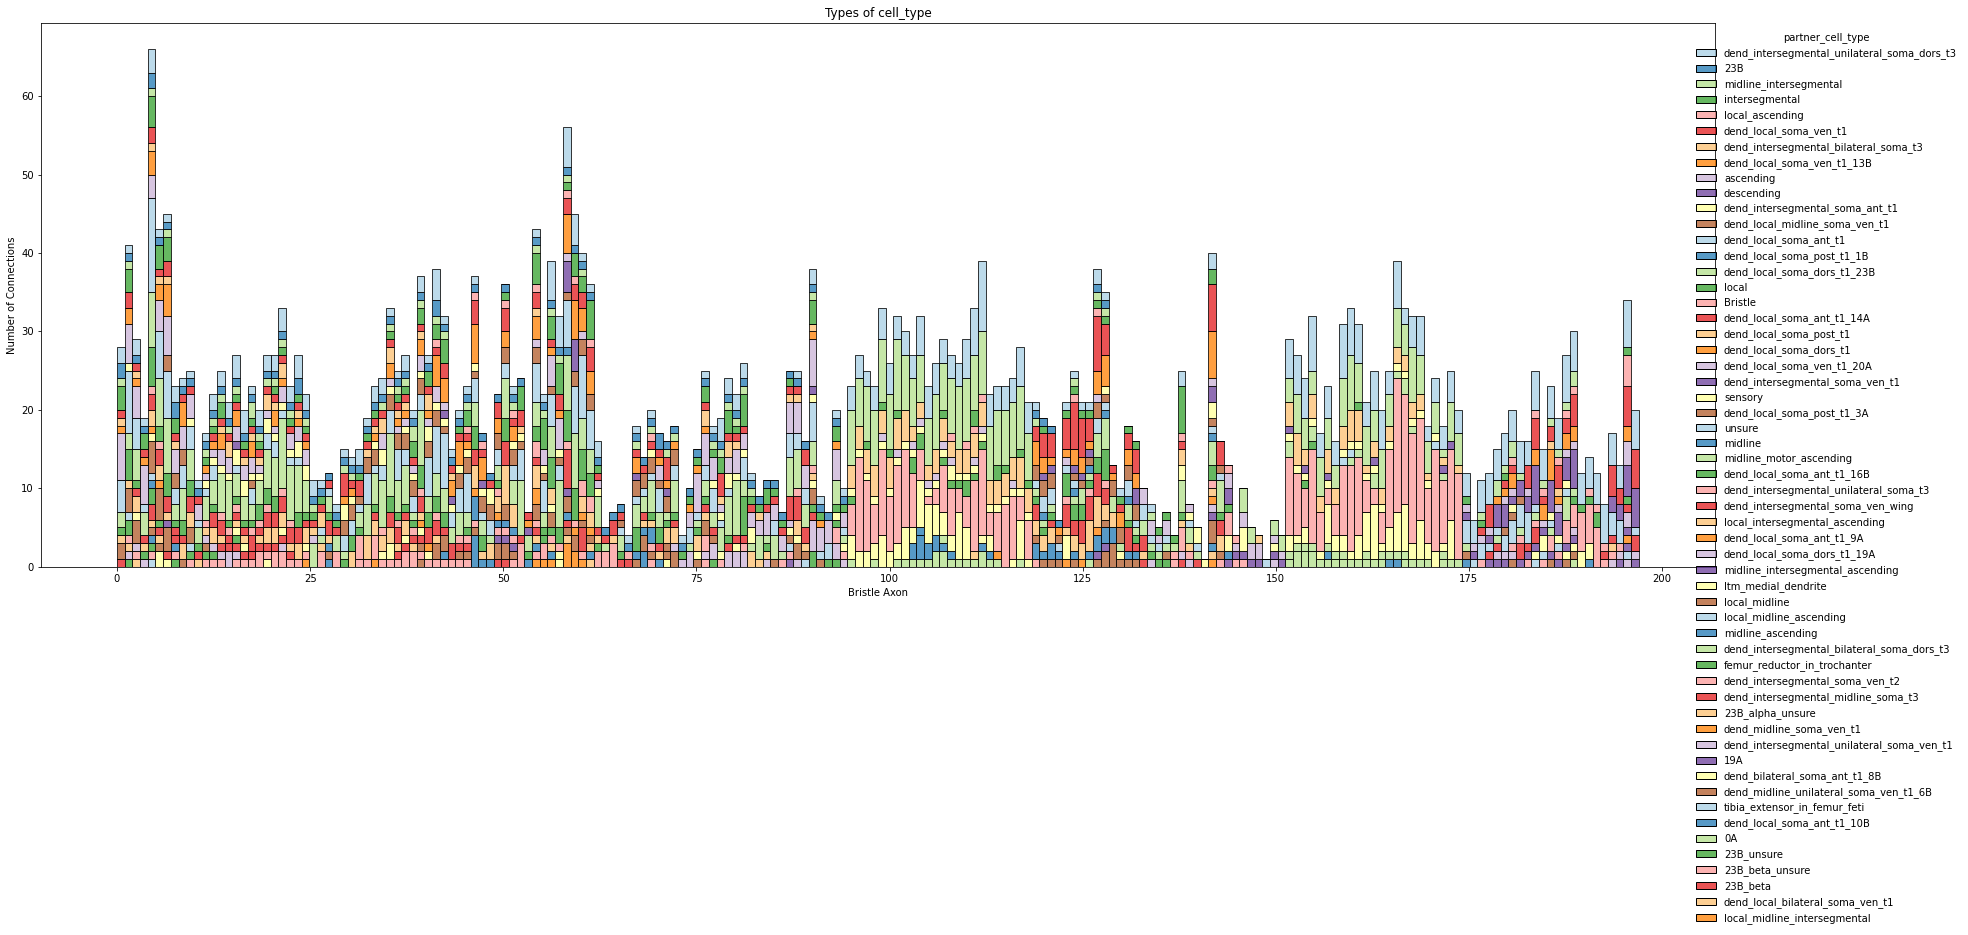

In [70]:
downs = sns_hist_cos_sim(downstream_edges, df_edges, bins, hue='partner_cell_type', title='Types of cell_type')

(198, 829)


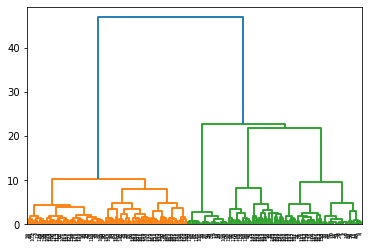

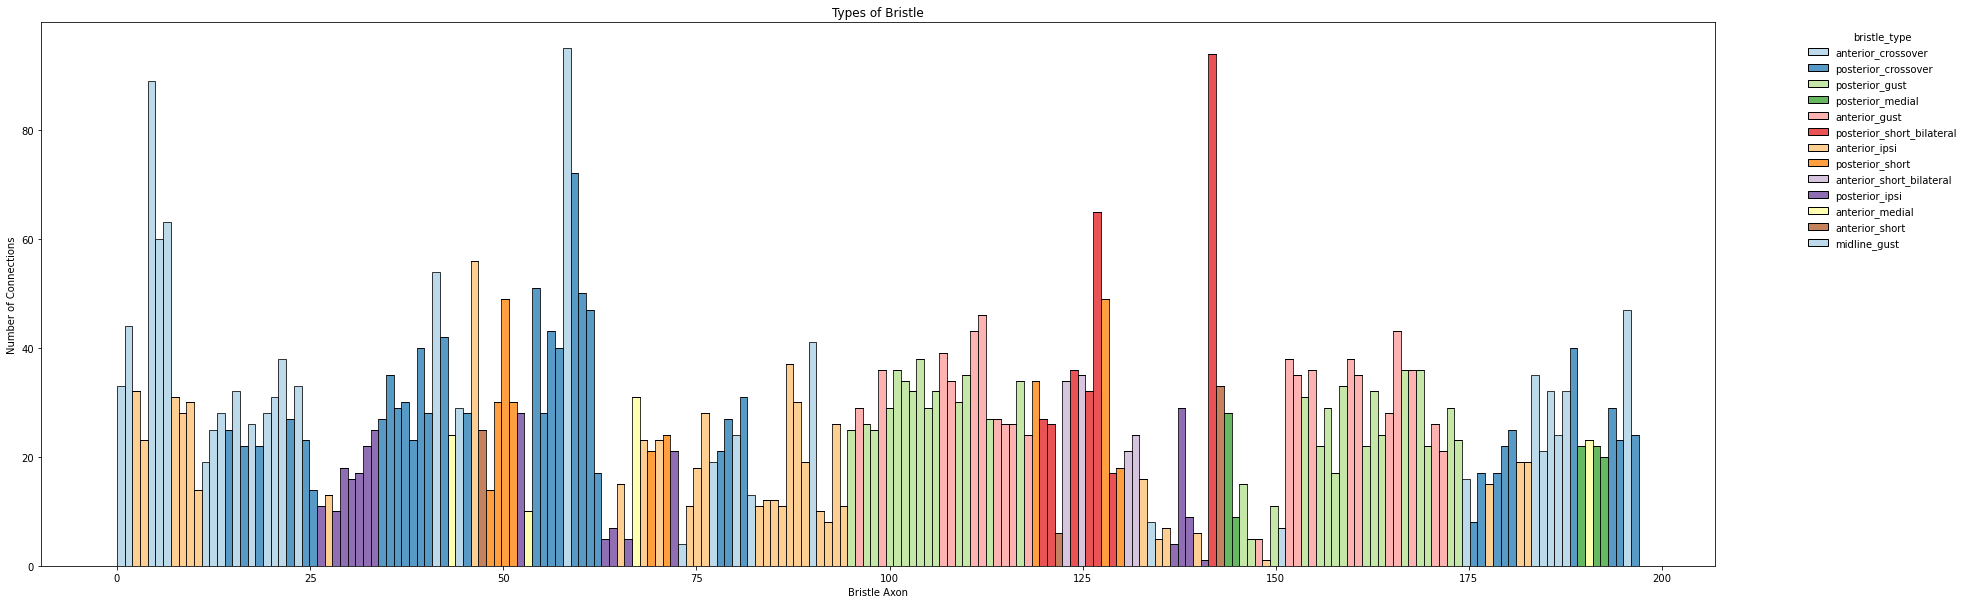

In [71]:
downs = sns_hist_cos_sim(downstream_edges, df_edges, 198, hue='bristle_type', title='Types of Bristle')

In [72]:
upstream_only = downs[downs.label=='upstream']
downstream_only = downs[downs.label=='downstream']
recurrent = downs[downs.label=='recurrent']

In [73]:
df_edges.head(1)

pre_pt_root_id     post_pt_root_id  partner_pt_root_id  \
0  648518346494876298  648518346502021449  648518346502021449   

   bristle_pt_root_id      label        bristle_type  \
0  648518346494876298  recurrent  anterior_crossover   

  partner_classification_system                            partner_cell_type  \
0                  ax_ascending  dend_intersegmental_unilateral_soma_dors_t3   

   count  order  
0     90    196

In [74]:
downs

pre_pt_root_id     post_pt_root_id  partner_pt_root_id  \
0     648518346494876298  648518346502021449  648518346502021449   
1     648518346490400604  648518346502021449  648518346502021449   
2     648518346480804573  648518346502021449  648518346502021449   
3     648518346486376873  648518346495973195  648518346495973195   
4     648518346494129655  648518346502021449  648518346502021449   
...                  ...                 ...                 ...   
5363  648518346467148526  648518346495775571  648518346495775571   
5364  648518346488087376  648518346486563204  648518346486563204   
5365  648518346494281467  648518346473053028  648518346494281467   
5366  648518346512802718  648518346504109864  648518346504109864   
5367  648518346500687795  648518346494882442  648518346500687795   

      bristle_pt_root_id       label         bristle_type  \
0     648518346494876298   recurrent   anterior_crossover   
1     648518346490400604   recurrent   anterior_crossover   
2     648518346480804573   recurrent   anterior_crossover   
3     648518346486376873   recurrent   anterior_crossover   
4     648518346494129655   recurrent  posterior_crossover   
...                  ...         ...                  ...   
5363  648518346467148526  downstream       posterior_gust   
5364  648518346488087376  downstream      posterior_short   
5365  648518346473053028   recurrent      anterior_medial   
5366  648518346512802718  downstream       posterior_ipsi   
5367  648518346494882442   recurrent       posterior_gust   

     partner_classification_system  \
0                     ax_ascending   
1                     ax_ascending   
2                     ax_ascending   
3                            local   
4                     ax_ascending   
...                            ...   
5363                           NaN   
5364                      ax_local   
5365                           NaN   
5366     ax_intersegmental_midline   
5367                           NaN   

                                partner_cell_type  count  order  
0     dend_intersegmental_unilateral_soma_dors_t3     90    196  
1     dend_intersegmental_unilateral_soma_dors_t3     71    186  
2     dend_intersegmental_unilateral_soma_dors_t3     66    187  
3                                             23B     59      5  
4     dend_intersegmental_unilateral_soma_dors_t3     57    197  
...                                           ...    ...    ...  
5363                                          NaN      4    150  
5364                      dend_local_soma_post_t1      4     51  
5365                                          NaN      4     67  
5366                  dend_local_soma_dors_t1_23B      4    137  
5367                                          NaN      4    163  

[5368 rows x 10 columns]

In [75]:
def hisplot(df, bins, title, hue='partner_classification_system'):
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(1,1,1)
    sns.histplot(data=df, ax=ax, multiple="stack",
                     x='order', bins = bins,
                     palette="Paired", hue=hue, 
                     element="bars", legend=True)
    ax.set_title(title)
    ax.set_xlabel("Bristle Axon")
    ax.set_ylabel("Number of Connections") # number of partners connected to
    sns.move_legend(ax, "upper right",frameon=False,bbox_to_anchor=(1.15, 1))

In [76]:
#recurrent.query('bristle_type!="gustatory" ').partner_cell_type.value_counts()

In [77]:
#downstream_only.query('bristle_type!="gustatory" & partner_cell_type == "dend_local_soma_post_t1_3A" & partner_pt_root_id == 648518346489502149')

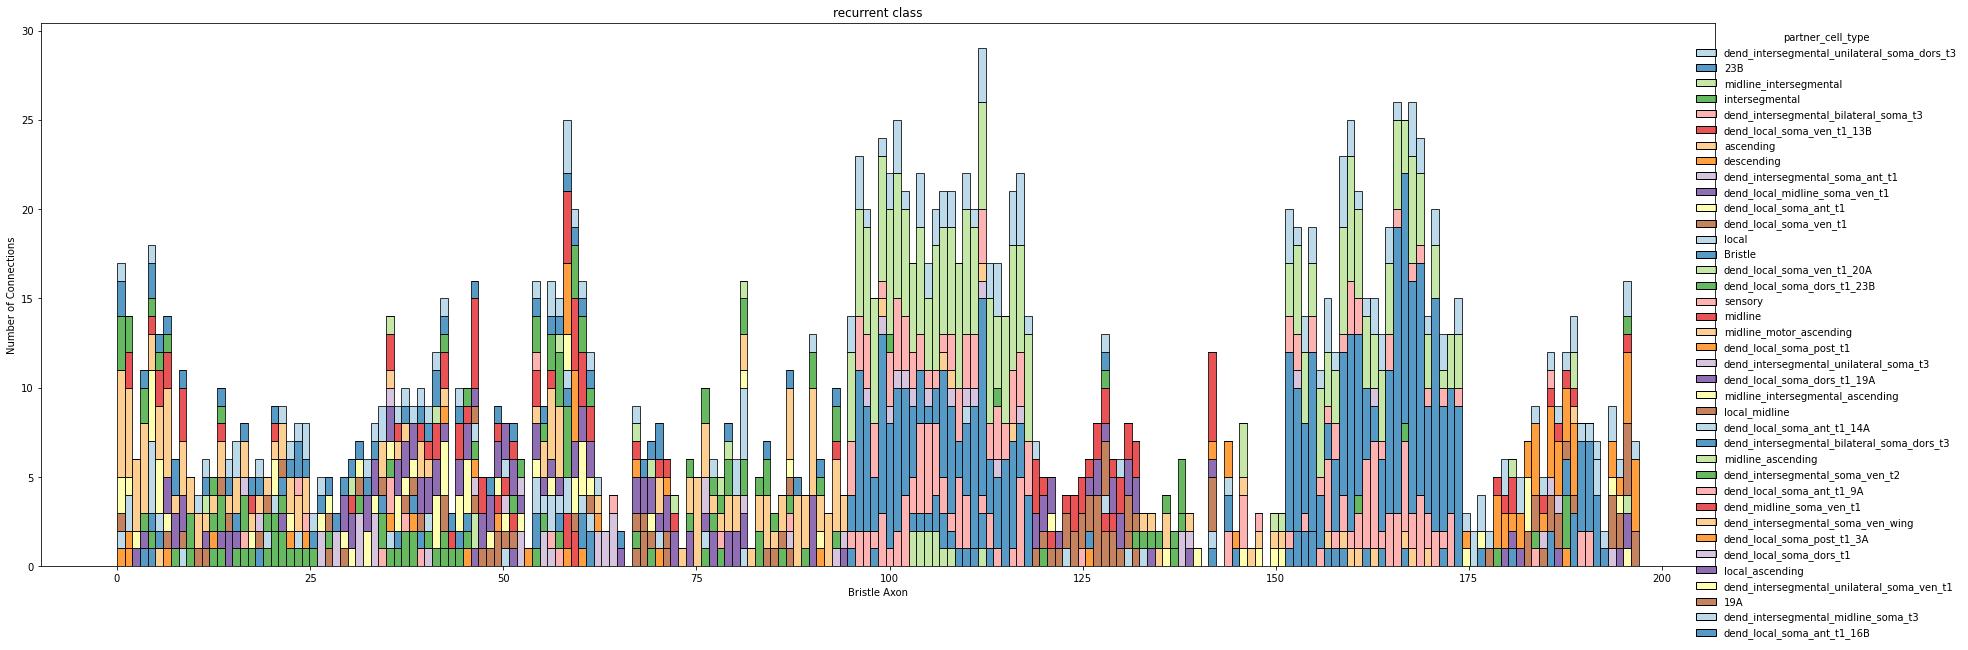

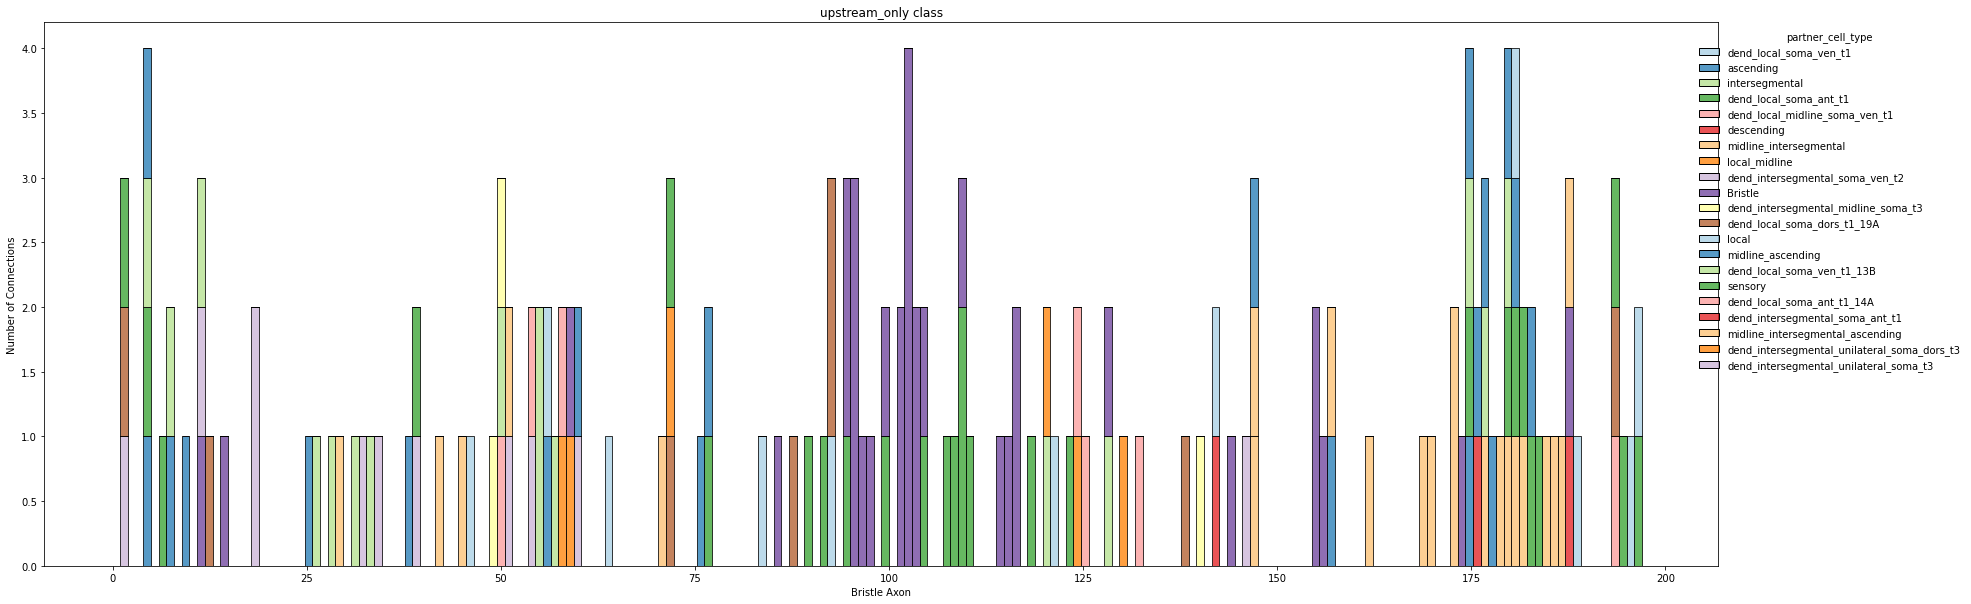

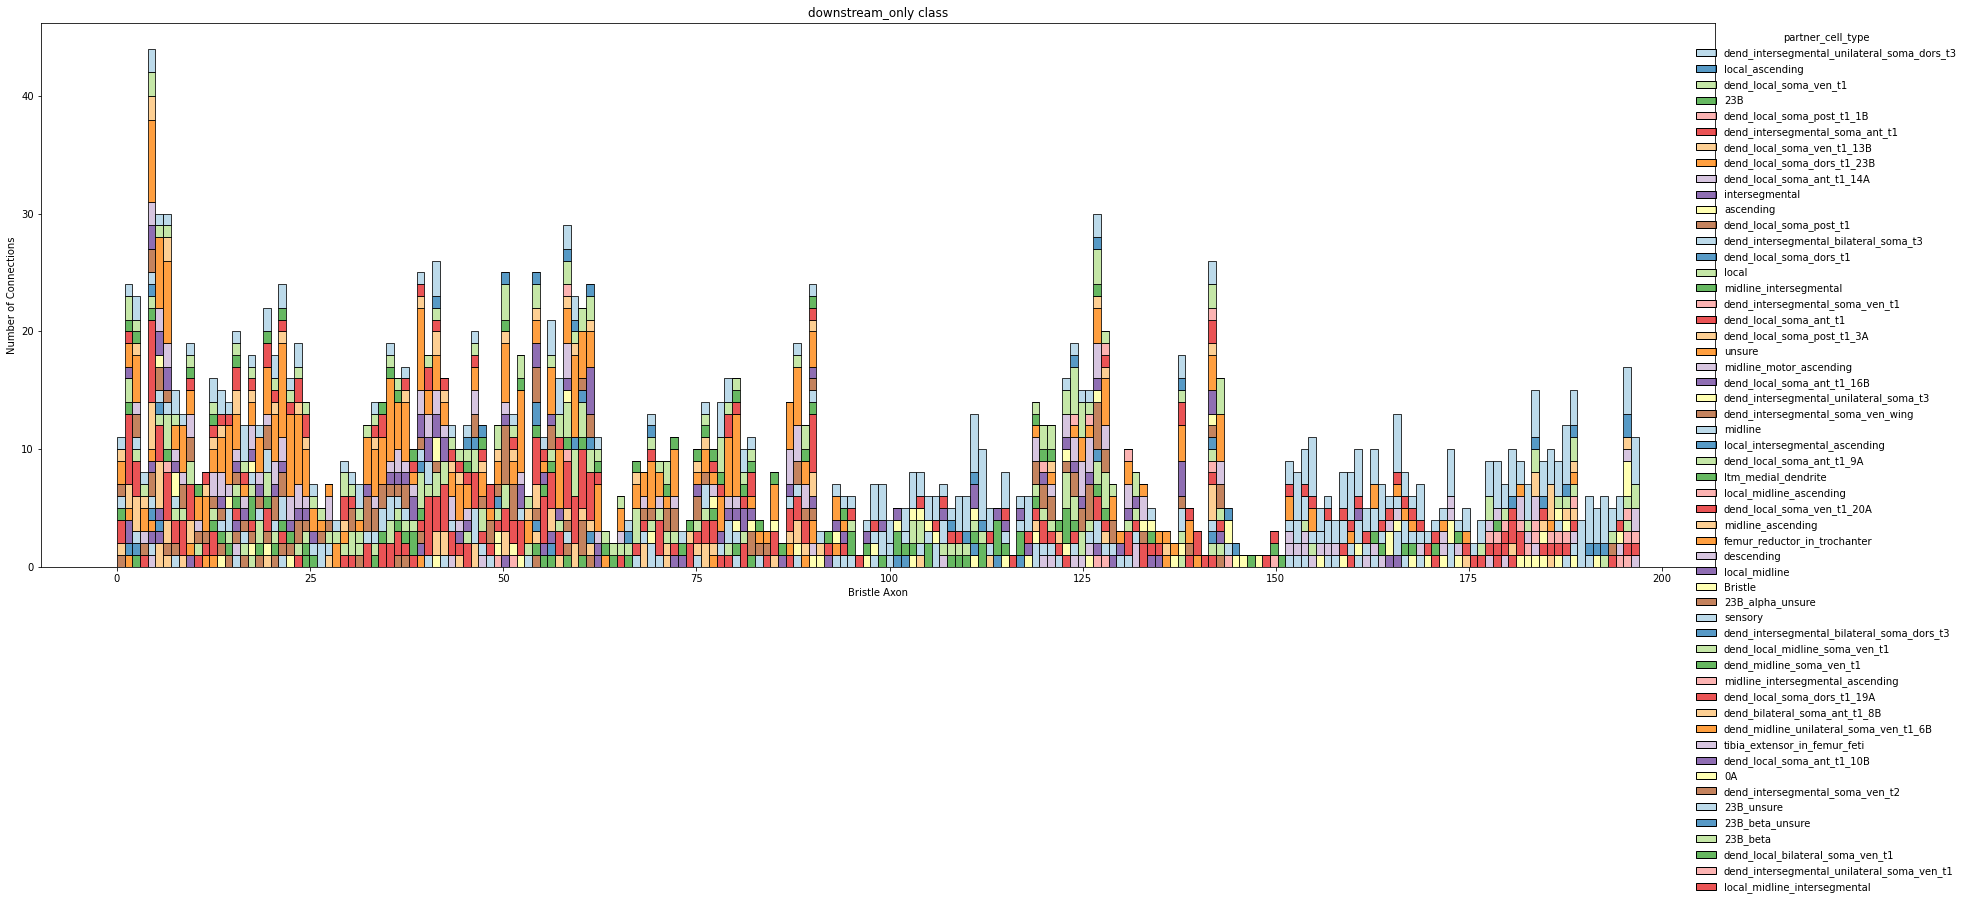

In [78]:
hisplot(recurrent, bins, 'recurrent class', hue='partner_cell_type')
hisplot(upstream_only, bins, 'upstream_only class', hue='partner_cell_type')
hisplot(downstream_only, bins, 'downstream_only class', hue='partner_cell_type')

In [79]:
print(df_edges.shape)
df_edges.head()

(5368, 10)


pre_pt_root_id     post_pt_root_id  partner_pt_root_id  \
0  648518346494876298  648518346502021449  648518346502021449   
1  648518346490400604  648518346502021449  648518346502021449   
2  648518346480804573  648518346502021449  648518346502021449   
3  648518346486376873  648518346495973195  648518346495973195   
4  648518346494129655  648518346502021449  648518346502021449   

   bristle_pt_root_id      label         bristle_type  \
0  648518346494876298  recurrent   anterior_crossover   
1  648518346490400604  recurrent   anterior_crossover   
2  648518346480804573  recurrent   anterior_crossover   
3  648518346486376873  recurrent   anterior_crossover   
4  648518346494129655  recurrent  posterior_crossover   

  partner_classification_system                            partner_cell_type  \
0                  ax_ascending  dend_intersegmental_unilateral_soma_dors_t3   
1                  ax_ascending  dend_intersegmental_unilateral_soma_dors_t3   
2                  ax_ascending  dend_intersegmental_unilateral_soma_dors_t3   
3                         local                                          23B   
4                  ax_ascending  dend_intersegmental_unilateral_soma_dors_t3   

   count  order  
0     90    196  
1     71    186  
2     66    187  
3     59      5  
4     57    197

In [80]:
tac_dct = check_partners(tac_dwn_lst, tac_up_lst)
gust_dct = check_partners(gust_dwn_lst, gust_up_lst)
short_dct = check_partners(short_dwn_lst, short_up_lst)

In [81]:
syn_gustatory_down_df['partner_pt_root_id'] = syn_gustatory_down_df['post_pt_root_id']
syn_tactile_down_df['partner_pt_root_id'] = syn_tactile_down_df['post_pt_root_id']
syn_short_down_df['partner_pt_root_id'] = syn_short_down_df['post_pt_root_id']

syn_gustatory_up_df['partner_pt_root_id'] = syn_gustatory_up_df['pre_pt_root_id']
syn_tactile_up_df['partner_pt_root_id'] = syn_tactile_up_df['pre_pt_root_id']
syn_short_up_df['partner_pt_root_id'] = syn_short_up_df['pre_pt_root_id']

In [82]:
syn_gustatory_down_df['bristle_pt_root_id'] = syn_gustatory_down_df['pre_pt_root_id']
syn_tactile_down_df['bristle_pt_root_id'] = syn_tactile_down_df['pre_pt_root_id']
syn_short_down_df['bristle_pt_root_id'] = syn_short_down_df['pre_pt_root_id']

syn_gustatory_up_df['bristle_pt_root_id'] = syn_gustatory_up_df['post_pt_root_id']
syn_tactile_up_df['bristle_pt_root_id'] = syn_tactile_up_df['post_pt_root_id']
syn_short_up_df['bristle_pt_root_id'] = syn_short_up_df['post_pt_root_id']

In [83]:
syn_gustatory_down_df.shape,syn_gustatory_up_df.shape,syn_tactile_down_df.shape,syn_tactile_up_df.shape,syn_short_down_df.shape,syn_short_up_df.shape

((0, 13), (0, 13), (0, 13), (0, 13), (0, 13), (0, 13))

In [84]:
syn_tactile_down_df.head()

Empty DataFrame
Columns: [id, created, superceded_id, valid, score, pre_pt_supervoxel_id, pre_pt_root_id, post_pt_supervoxel_id, post_pt_root_id, pre_pt_position, post_pt_position, partner_pt_root_id, bristle_pt_root_id]
Index: []

In [85]:
# concat all tables altogether into one
large_df = pd.concat([syn_gustatory_down_df, syn_gustatory_up_df, syn_tactile_down_df,
                      syn_tactile_up_df, syn_short_down_df, syn_short_up_df],
                      axis=0)
print(large_df.shape)
large_df.head()

(0, 13)


Empty DataFrame
Columns: [id, created, superceded_id, valid, score, pre_pt_supervoxel_id, pre_pt_root_id, post_pt_supervoxel_id, post_pt_root_id, pre_pt_position, post_pt_position, partner_pt_root_id, bristle_pt_root_id]
Index: []

In [86]:
large_df['tactile_partners'] = large_df['partner_pt_root_id'].map(tac_dct)
large_df['gustatory_partners'] = large_df['partner_pt_root_id'].map(gust_dct)
large_df['short_partners'] = large_df['partner_pt_root_id'].map(short_dct)
large_df['classification_system'] = large_df['partner_pt_root_id'].map(partner_class_dct)

In [87]:
large_df.head()

Empty DataFrame
Columns: [id, created, superceded_id, valid, score, pre_pt_supervoxel_id, pre_pt_root_id, post_pt_supervoxel_id, post_pt_root_id, pre_pt_position, post_pt_position, partner_pt_root_id, bristle_pt_root_id, tactile_partners, gustatory_partners, short_partners, classification_system]
Index: []

In [88]:
large_df.shape

(0, 17)

In [89]:
large_df[large_df.short_partners!='None'].head()

Empty DataFrame
Columns: [id, created, superceded_id, valid, score, pre_pt_supervoxel_id, pre_pt_root_id, post_pt_supervoxel_id, post_pt_root_id, pre_pt_position, post_pt_position, partner_pt_root_id, bristle_pt_root_id, tactile_partners, gustatory_partners, short_partners, classification_system]
Index: []

In [90]:
large_df[large_df.duplicated(subset=['id'])]

Empty DataFrame
Columns: [id, created, superceded_id, valid, score, pre_pt_supervoxel_id, pre_pt_root_id, post_pt_supervoxel_id, post_pt_root_id, pre_pt_position, post_pt_position, partner_pt_root_id, bristle_pt_root_id, tactile_partners, gustatory_partners, short_partners, classification_system]
Index: []

In [91]:
large_df.to_pickle("C:/Users/trnan/OneDrive/Desktop/uw/Tutill lab/repos/large_df")

In [92]:
#large_df.loc[(large_df['tactile_partners']== 'None') & (large_df['gustatory_partners']=='None')]

In [93]:
#print(leg_df.shape)
#leg_wing_list = list(dwn_df.pt_root_id.unique())
#leg_downstream_list = list(leg_df.pt_root_id.unique())

upstream_leg_df = client.materialize.synapse_query(post_ids=leg_df.pt_root_id)
up_without_dwn_df = upstream_leg_df[~upstream_leg_df['pre_pt_root_id'].isin(dwn_df['pt_root_id'])]
upstream_leg_df.shape, up_without_dwn_df.shape

((22139, 11), (9492, 11))

In [94]:
up_without_dwn_df.head()

id                          created  superceded_id valid  score  \
0  39942491 2022-11-17 14:28:59.843347+00:00            NaN     t     45   
1  26805535 2022-11-17 14:28:59.843347+00:00            NaN     t     47   
3   4275890 2022-11-17 14:28:59.843347+00:00            NaN     t     21   
4  14746079 2022-11-17 14:28:59.843347+00:00            NaN     t     32   
5  40047959 2022-11-17 14:28:59.843347+00:00            NaN     t     43   

   pre_pt_supervoxel_id      pre_pt_root_id  post_pt_supervoxel_id  \
0     72483519166916611  648518346466840942      72483519166925224   
1     73046125388816042  648518346490492170      73046125388820814   
3     72975894016563344  648518346466840942      72975894016571776   
4     72483381728062059  648518346466840942      72483381728052366   
5     72835500125621167  648518346474368109      72835500125616601   

      post_pt_root_id        pre_pt_position       post_pt_position  
0  648518346494342002  [13735, 111021, 3488]  [13703, 111031, 3490]  
1  648518346479505874  [29249, 101925, 3265]  [29241, 101961, 3266]  
3  648518346518790367  [26717, 106377, 3160]  [26725, 106367, 3163]  
4  648518346479212732  [13273, 108089, 3518]  [13263, 108077, 3520]  
5  648518346504874611  [23731, 115543, 3180]  [23707, 115579, 3180]

In [95]:
#up_without_dwn_df.to_pickle("C:/Users/trnan/OneDrive/Desktop/uw/Tutill lab/repos/upstream_bristle_partners_without_downstream_parners")

In [96]:
up_without_dwn_df.pre_pt_root_id.unique().shape

(2677,)

In [97]:
large_df.head()

Empty DataFrame
Columns: [id, created, superceded_id, valid, score, pre_pt_supervoxel_id, pre_pt_root_id, post_pt_supervoxel_id, post_pt_root_id, pre_pt_position, post_pt_position, partner_pt_root_id, bristle_pt_root_id, tactile_partners, gustatory_partners, short_partners, classification_system]
Index: []

In [98]:
# needs pre-processing for 
def count_num(original, choice='upstream'):
    dct = {k: [] for k in original.classification_system.unique()}
    for kind in ['tactile_partners','short_partners','gustatory_partners']:
        df = original[original[kind] == choice]
        for classi in dct:
            if classi!=classi:
                dct[classi] += [len(df[df.classification_system.isna()].partner_pt_root_id.unique())]
            else:
                dct[classi] += [len(df[df.classification_system == classi].partner_pt_root_id.unique())]
    new_df = pd.DataFrame.from_dict(dct, orient='index', columns=['tactile_partners','short_partners','gustatory_partners'])
    return new_df

In [99]:
len(large_df.loc[(large_df.classification_system.isna()) 
                 & (large_df.tactile_partners=='upstream')].partner_pt_root_id.unique())

0

In [100]:
upstream_only_df = count_num(large_df, choice='upstream')
downstream_only_df = count_num(large_df, choice='downstream')
recurrent_df = count_num(large_df, choice='recurrent')

In [101]:
large_df.classification_system.unique()

array([], dtype=object)

In [102]:
large_df.head()

Empty DataFrame
Columns: [id, created, superceded_id, valid, score, pre_pt_supervoxel_id, pre_pt_root_id, post_pt_supervoxel_id, post_pt_root_id, pre_pt_position, post_pt_position, partner_pt_root_id, bristle_pt_root_id, tactile_partners, gustatory_partners, short_partners, classification_system]
Index: []

In [103]:
leg_df.pt_root_id.value_counts()

648518346486376873    1
648518346480419286    1
648518346484769693    1
648518346511906928    1
648518346490411100    1
                     ..
648518346494703493    1
648518346478700628    1
648518346498386514    1
648518346493069232    1
648518346491234081    1
Name: pt_root_id, Length: 199, dtype: int64

In [104]:
upstream_only_df.sort_values(by='tactile_partners',ascending=False)

Empty DataFrame
Columns: [tactile_partners, short_partners, gustatory_partners]
Index: []

In [105]:
len(large_df.loc[(large_df.classification_system.isna()) 
                 & (large_df.tactile_partners=='downstream')].partner_pt_root_id.unique())

0

In [106]:
downstream_only_df.sort_values(by='tactile_partners',ascending=False)

Empty DataFrame
Columns: [tactile_partners, short_partners, gustatory_partners]
Index: []

In [107]:
recurrent_df

Empty DataFrame
Columns: [tactile_partners, short_partners, gustatory_partners]
Index: []

In [108]:
large_df_edges = large_df.groupby(['pre_pt_root_id', 'post_pt_root_id','partner_pt_root_id','bristle_pt_root_id',
                                   'tactile_partners','gustatory_partners','short_partners','classification_system'], 
                                   dropna=False).size().sort_values(ascending=False).reset_index(name='count')
#large_df_edges = large_df_edges.query('count > 3')

In [109]:
partner_tactile_lst_rec = large_df_edges.loc[(large_df_edges.classification_system=='sensory') 
                                   & (large_df_edges.tactile_partners=='recurrent')].partner_pt_root_id.unique()
partner_tactile_lst_dwn = large_df_edges.loc[(large_df_edges.classification_system=='sensory') & 
                          (large_df_edges.tactile_partners=='downstream')].partner_pt_root_id.unique()
partner_tactile_lst = np.append(partner_tactile_lst_rec,partner_tactile_lst_dwn)

partner_gustatory_lst_rec = large_df_edges.loc[(large_df_edges.classification_system=='sensory') 
                                             & (large_df_edges.gustatory_partners=='recurrent')].partner_pt_root_id.unique()
partner_gustatory_lst_dwn = large_df_edges.loc[(large_df_edges.classification_system=='sensory') & 
                                               (large_df_edges.gustatory_partners=='downstream')].partner_pt_root_id.unique()
partner_gustatory_lst = np.append(partner_gustatory_lst_rec,partner_gustatory_lst_dwn)

In [110]:
len(partner_tactile_lst), len(partner_gustatory_lst)

(0, 0)

In [111]:
len(client.materialize.synapse_query(post_ids=partner_tactile_lst))

0

In [112]:
len(client.materialize.synapse_query(post_ids=partner_gustatory_lst))

0

In [113]:
large_df_edges.head()

Empty DataFrame
Columns: [pre_pt_root_id, post_pt_root_id, partner_pt_root_id, bristle_pt_root_id, tactile_partners, gustatory_partners, short_partners, classification_system, count]
Index: []

In [114]:
#large_df_edges.to_pickle("C:/Users/trnan/OneDrive/Desktop/uw/Tutill lab/repos/large_df_edges")

In [115]:
large_df_edges.loc[(large_df_edges.pre_pt_root_id==648518346511927231) 
                   & (large_df_edges.post_pt_root_id == 648518346475457664)]

Empty DataFrame
Columns: [pre_pt_root_id, post_pt_root_id, partner_pt_root_id, bristle_pt_root_id, tactile_partners, gustatory_partners, short_partners, classification_system, count]
Index: []

In [116]:
upstream_only = count_num(large_df_edges, choice='upstream')
downstream_only = count_num(large_df_edges, choice='downstream')
recurrent = count_num(large_df_edges, choice='recurrent')

In [117]:
upstream_only.to_pickle("C:/Users/trnan/OneDrive/Desktop/uw/Tutill lab/repos/upstream_only")
downstream_only.to_pickle("C:/Users/trnan/OneDrive/Desktop/uw/Tutill lab/repos/downstream_only")
recurrent.to_pickle("C:/Users/trnan/OneDrive/Desktop/uw/Tutill lab/repos/recurrent")

In [118]:
upstream_only.sort_values(by='tactile_partners',ascending=False)

Empty DataFrame
Columns: [tactile_partners, short_partners, gustatory_partners]
Index: []

In [119]:
len(large_df_edges.loc[(large_df_edges.classification_system.isna())
                       & (large_df_edges.tactile_partners=='downstream')].partner_pt_root_id.unique())

0

In [120]:
downstream_only.sort_values(by='tactile_partners',ascending=False)

Empty DataFrame
Columns: [tactile_partners, short_partners, gustatory_partners]
Index: []

In [121]:
recurrent.sort_values(by='tactile_partners',ascending=False)

Empty DataFrame
Columns: [tactile_partners, short_partners, gustatory_partners]
Index: []